# we want to categorize each cell as adapting or sensitizing based on LN threshold

In [1]:
import matplotlib
matplotlib.use('Agg')

import numpy as np
import collections
from functools import partial
from os.path import expanduser
from tqdm import tqdm
import h5py

from surround.image_processing import *
from surround.data_handling import *
from surround.efficient_coding import *
from aesthetics.plotting import *
from surround.modeling import gaussian, difference_of_gaussians

import pyret.filtertools as ft
from pyret.spiketools import binspikes
from pyret.filtertools import sta, decompose
from pyret.nonlinearities import Binterp, Sigmoid

import pyret.filtertools as ft
from sklearn.decomposition import PCA
from scipy.stats import sem, zscore
from scipy.optimize import curve_fit, minimize
from scipy.interpolate import interp1d
from scipy.stats import pearsonr

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

plt.style.use('deepretina')

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

/home/lane/.local/lib/python3.5/site-packages/matplotlib-2.0.0-py3.5-linux-x86_64.egg/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/home/lane/.local/lib/python3.5/site-packages/matplotlib-2.0.0-py3.5-linux-x86_64.egg/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")
/home/lane/.local/lib/python3.5/site-packages/matplotlib-2.0.0-py3.5-linux-x86_64.egg/matplotlib/style/core.py:53: UserWarning: Style includes a parameter, 'interactive', that is not related to style.  Ignoring
  "to style.  Ignoring".format(key))
/home/lane/.local/lib/python3.5/site-packages/matplotlib-2.0.0-py3.5-linux-x86_64.egg/matplotlib/style/core.py:53: UserWarning: Style includes a parameter, 'timezone', that is not related to style.  Ignoring
  "to style.  Ignoring".format(key))
/home/lane/.l

### Verify that nonlinearities.sigmoid is working properly

In [3]:
x = np.linspace(-5,5,100)
y = -3. + 5. / (1. + np.exp(-0.5 * (x - 10.)))
this_sigmoid = Sigmoid()
this_sigmoid.fit(x, y)

Sigmoid(baseline=-3.0, peak=4.9999999999998836, slope=0.50000000000000078,
    threshold=9.9999999999999414)

# Load data

In [ ]:
# test_set_size = 2000
sample_rate = 100.
nbins = 50
filter_length = 40
delta_after = 0 # we really should reshift these datasets, because even delta_after = 2 helps STA
expts = ['15-10-07', '15-11-21a', '15-11-21b', '16-01-07', '16-01-08']
all_stas = collections.defaultdict(list)
all_nonlinearities = collections.defaultdict(list)
all_thresholds = collections.defaultdict(list)
for expt in expts:
    with h5py.File(expanduser('~/experiments/data/' + expt + '/whitenoise.h5'), 'r') as h:
        time = np.array(h['train/time'])
        zscored_stim = zscore(h['train/stimulus'])
        for cell in tqdm(range(h['train/response/binned'].shape[0])):
            # get spike times from binned spikes
            spike_times = [time[t] for t,r in enumerate(h['train/response/binned'][cell]) if r > 0]
            
            # compute STA and store it
            this_sta, tax = sta(time, zscored_stim, spike_times, 
                                nsamples_before=filter_length-delta_after, nsamples_after=delta_after)
            all_stas[expt].append(this_sta)
            
            # compute linear prediction and nonlinearity
            pred = ft.linear_response(this_sta, zscored_stim)
            true_rate = np.array(h['train/response/firing_rate_10ms'][cell][(filter_length-1):])
#             this_binterp = Binterp(nbins)
#             this_binterp.fit(pred, true_rate)
#             all_nonlinearities.append((this_binterp.bins, this_binterp.values))
            this_sigmoid = Sigmoid()
            this_sigmoid.fit(pred, true_rate)
            all_nonlinearities[expt].append(this_sigmoid)
            all_thresholds[expt].append(this_sigmoid.threshold) # right now pyret mislabels threshold as slope

 36%|███▌      | 5/14 [01:25<02:32, 16.93s/it]/home/lane/ssd/code/pyret/pyret/nonlinearities.py:82: RuntimeWarning: overflow encountered in exp
  return baseline + peak / (1 + np.exp(-slope * (x - threshold)))
  0%|          | 0/27 [00:00<?, ?it/s]/home/lane/ssd/code/pyret/pyret/nonlinearities.py:82: RuntimeWarning: overflow encountered in exp
  return baseline + peak / (1 + np.exp(-slope * (x - threshold)))
 41%|████      | 11/27 [03:05<04:36, 17.28s/it]

In [41]:
this_binterp.bins

array([-21.9235989 , -11.07449413,  -9.56475982,  -8.59707853,
        -7.84186559,  -7.19141341,  -6.63817   ,  -6.15631358,
        -5.71850143,  -5.31274515,  -4.93260156,  -4.5730469 ,
        -4.23712344,  -3.90709494,  -3.58238804,  -3.274177  ,
        -2.97482295,  -2.68113427,  -2.38861313,  -2.1081717 ,
        -1.82095383,  -1.547764  ,  -1.26931732,  -0.99486662,
        -0.71725527,  -0.43283449,  -0.15368436,   0.1247625 ,
         0.40925808,   0.70228061,   1.00317719,   1.30602587,
         1.61181397,   1.927859  ,   2.25687741,   2.59815112,
         2.95795614,   3.33564016,   3.73149103,   4.15767367,
         4.6147471 ,   5.11137387,   5.66119089,   6.27281363,
         6.95809385,   7.77414412,   8.74367917,   9.97062025,
        11.64713754,  14.23020919,  27.49295114])

In [48]:
this_binterp.values

array([   0.26945493,    0.38576612,    0.38251559,    0.54475915,
          0.56030248,    0.61789182,    0.74302588,    0.71717545,
          0.94476628,    0.8253299 ,    0.93958883,    1.10105597,
          1.15848735,    1.23058063,    1.38849502,    1.39126434,
          1.51924726,    1.53883083,    1.72567131,    1.81457586,
          1.90456602,    2.14941426,    2.18443317,    2.35555444,
          2.50474225,    2.77382738,    2.86530712,    2.98260224,
          3.50742636,    3.77140733,    3.71712812,    4.11919333,
          4.74633662,    4.93817952,    5.51424621,    5.88652706,
          6.48842921,    7.15116534,    8.11206111,    8.96337235,
         10.10046901,   11.42753013,   13.11638718,   15.26967115,
         17.73229435,   21.08001594,   25.98798362,   32.75282878,
         42.29910864,   61.30406548,  105.45984106])

In [51]:
np.std(pred)

5.9871795016293445

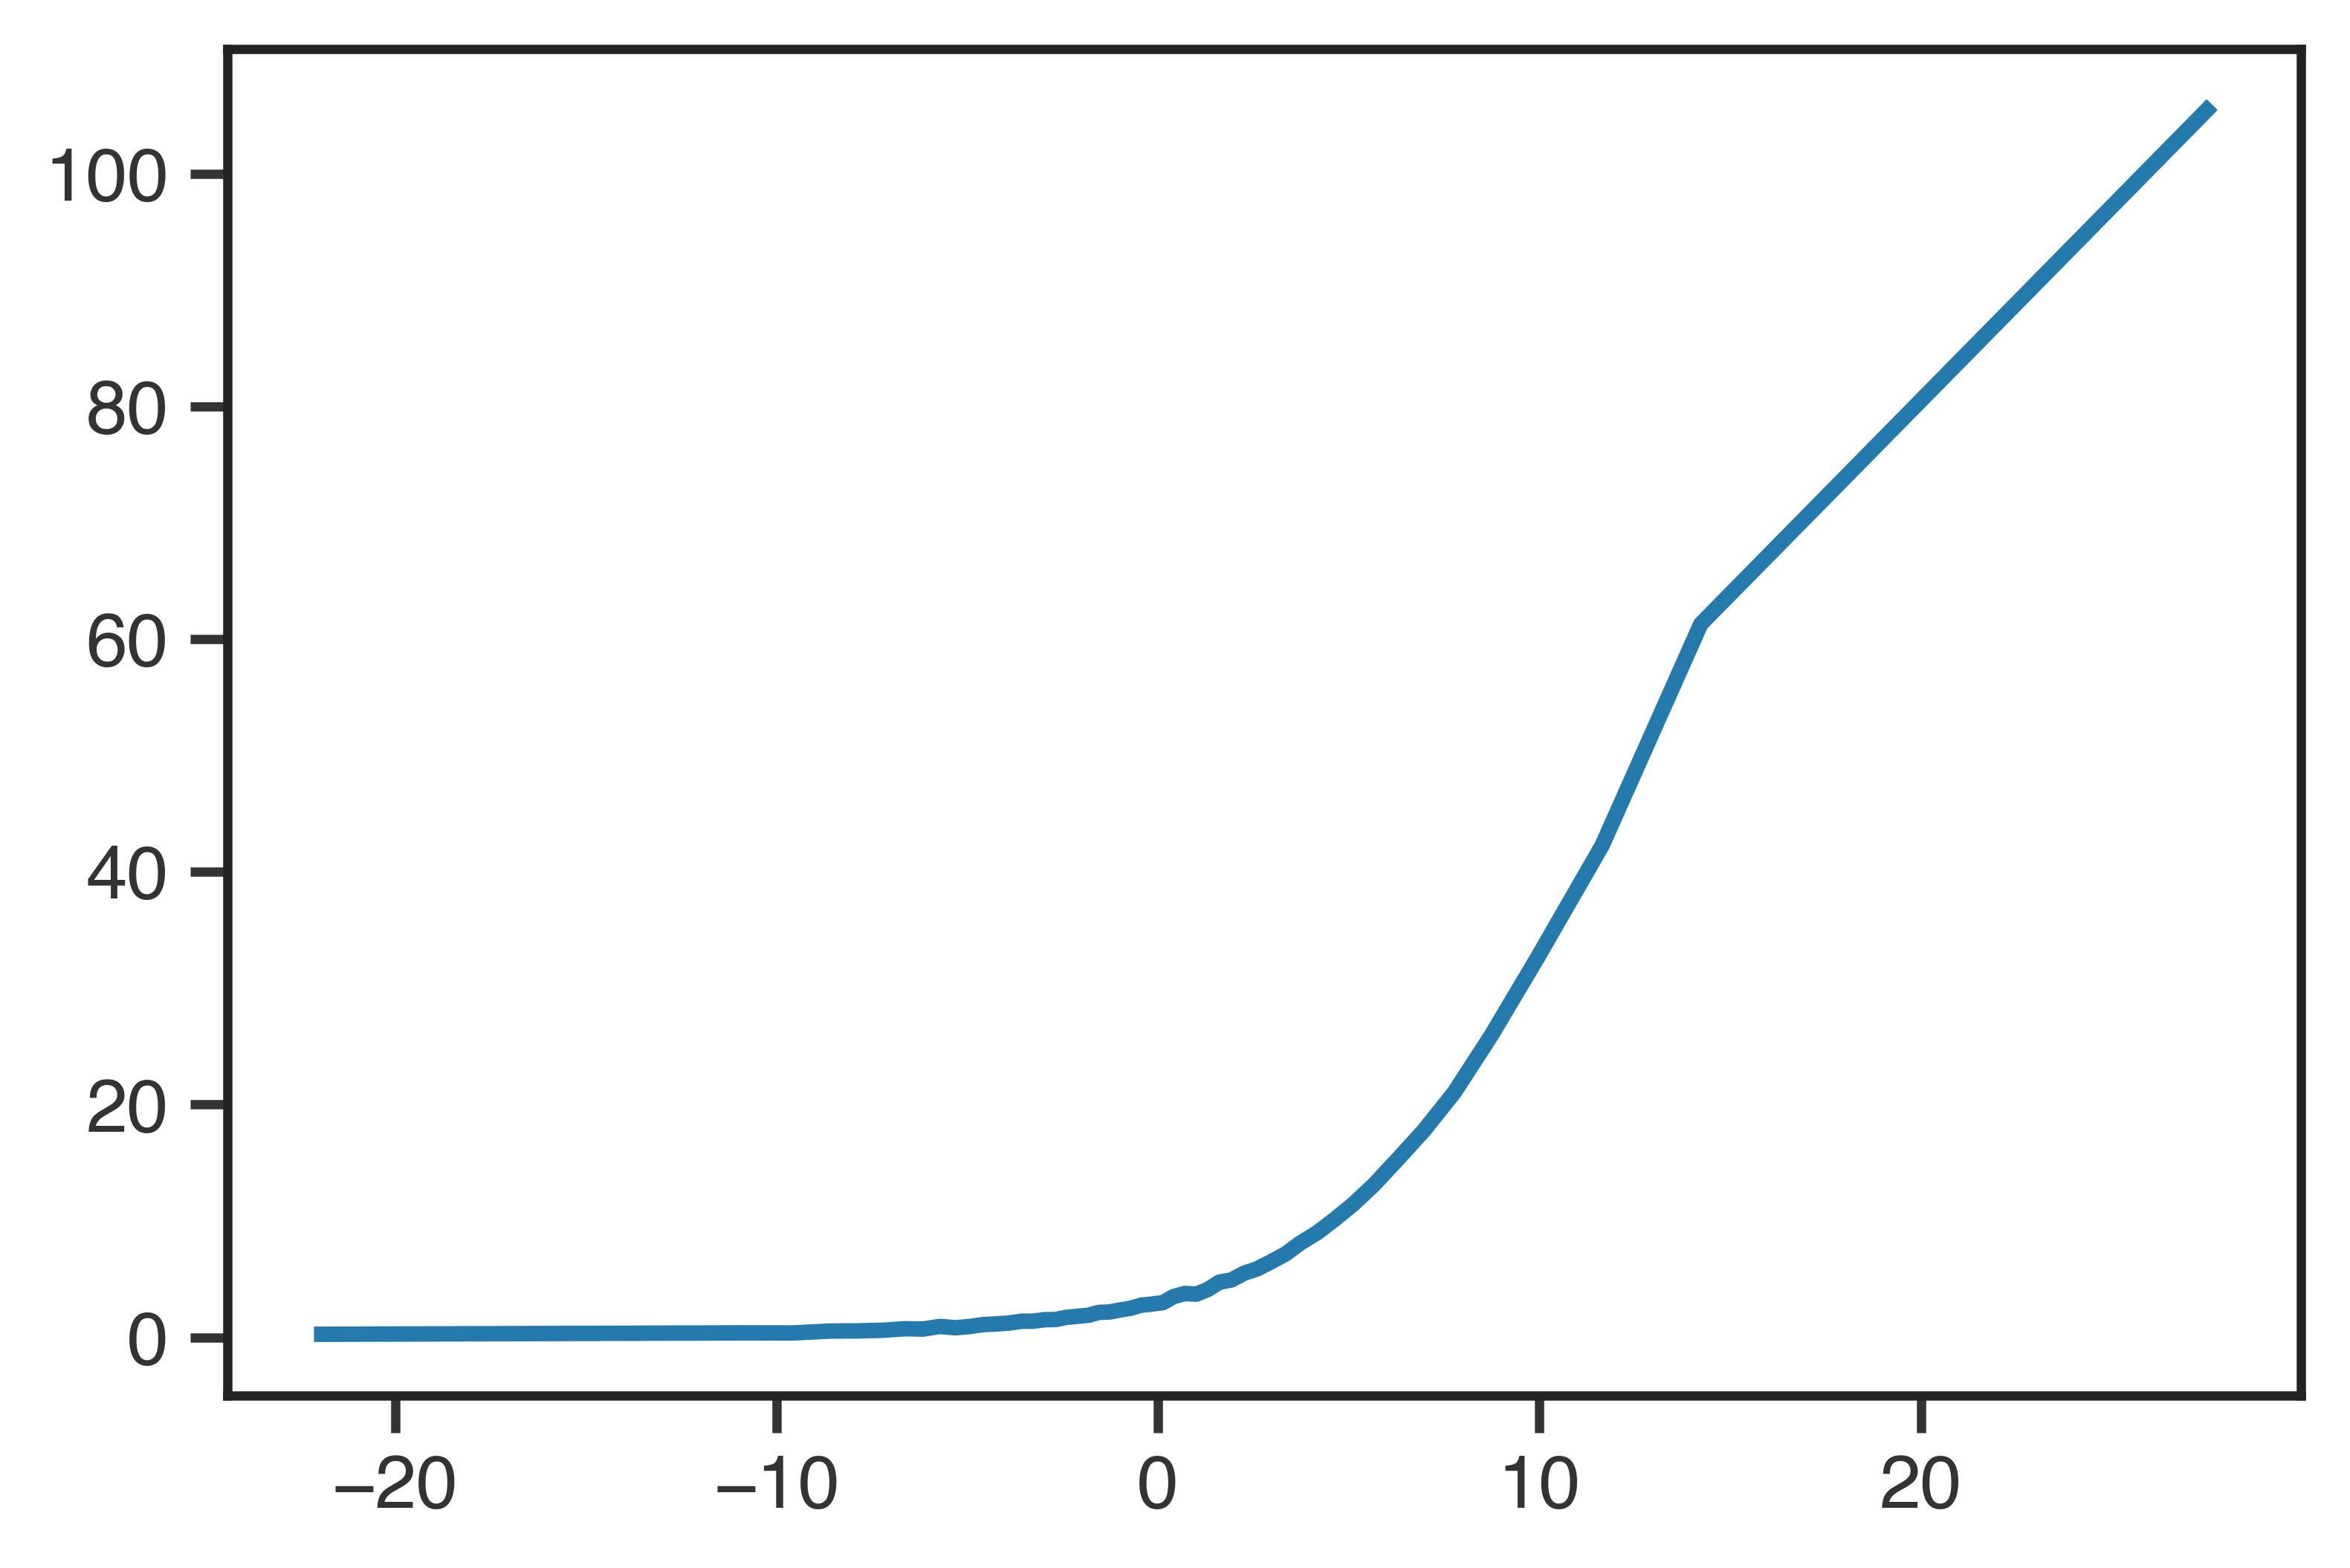

In [49]:
plt.plot(this_binterp.bins, this_binterp.values)

In [55]:
this_sigmoid

Sigmoid(baseline=0.25298275109460044, peak=-0.17980367424859112,
    slope=12.595252247992985, threshold=83.5130741668534)

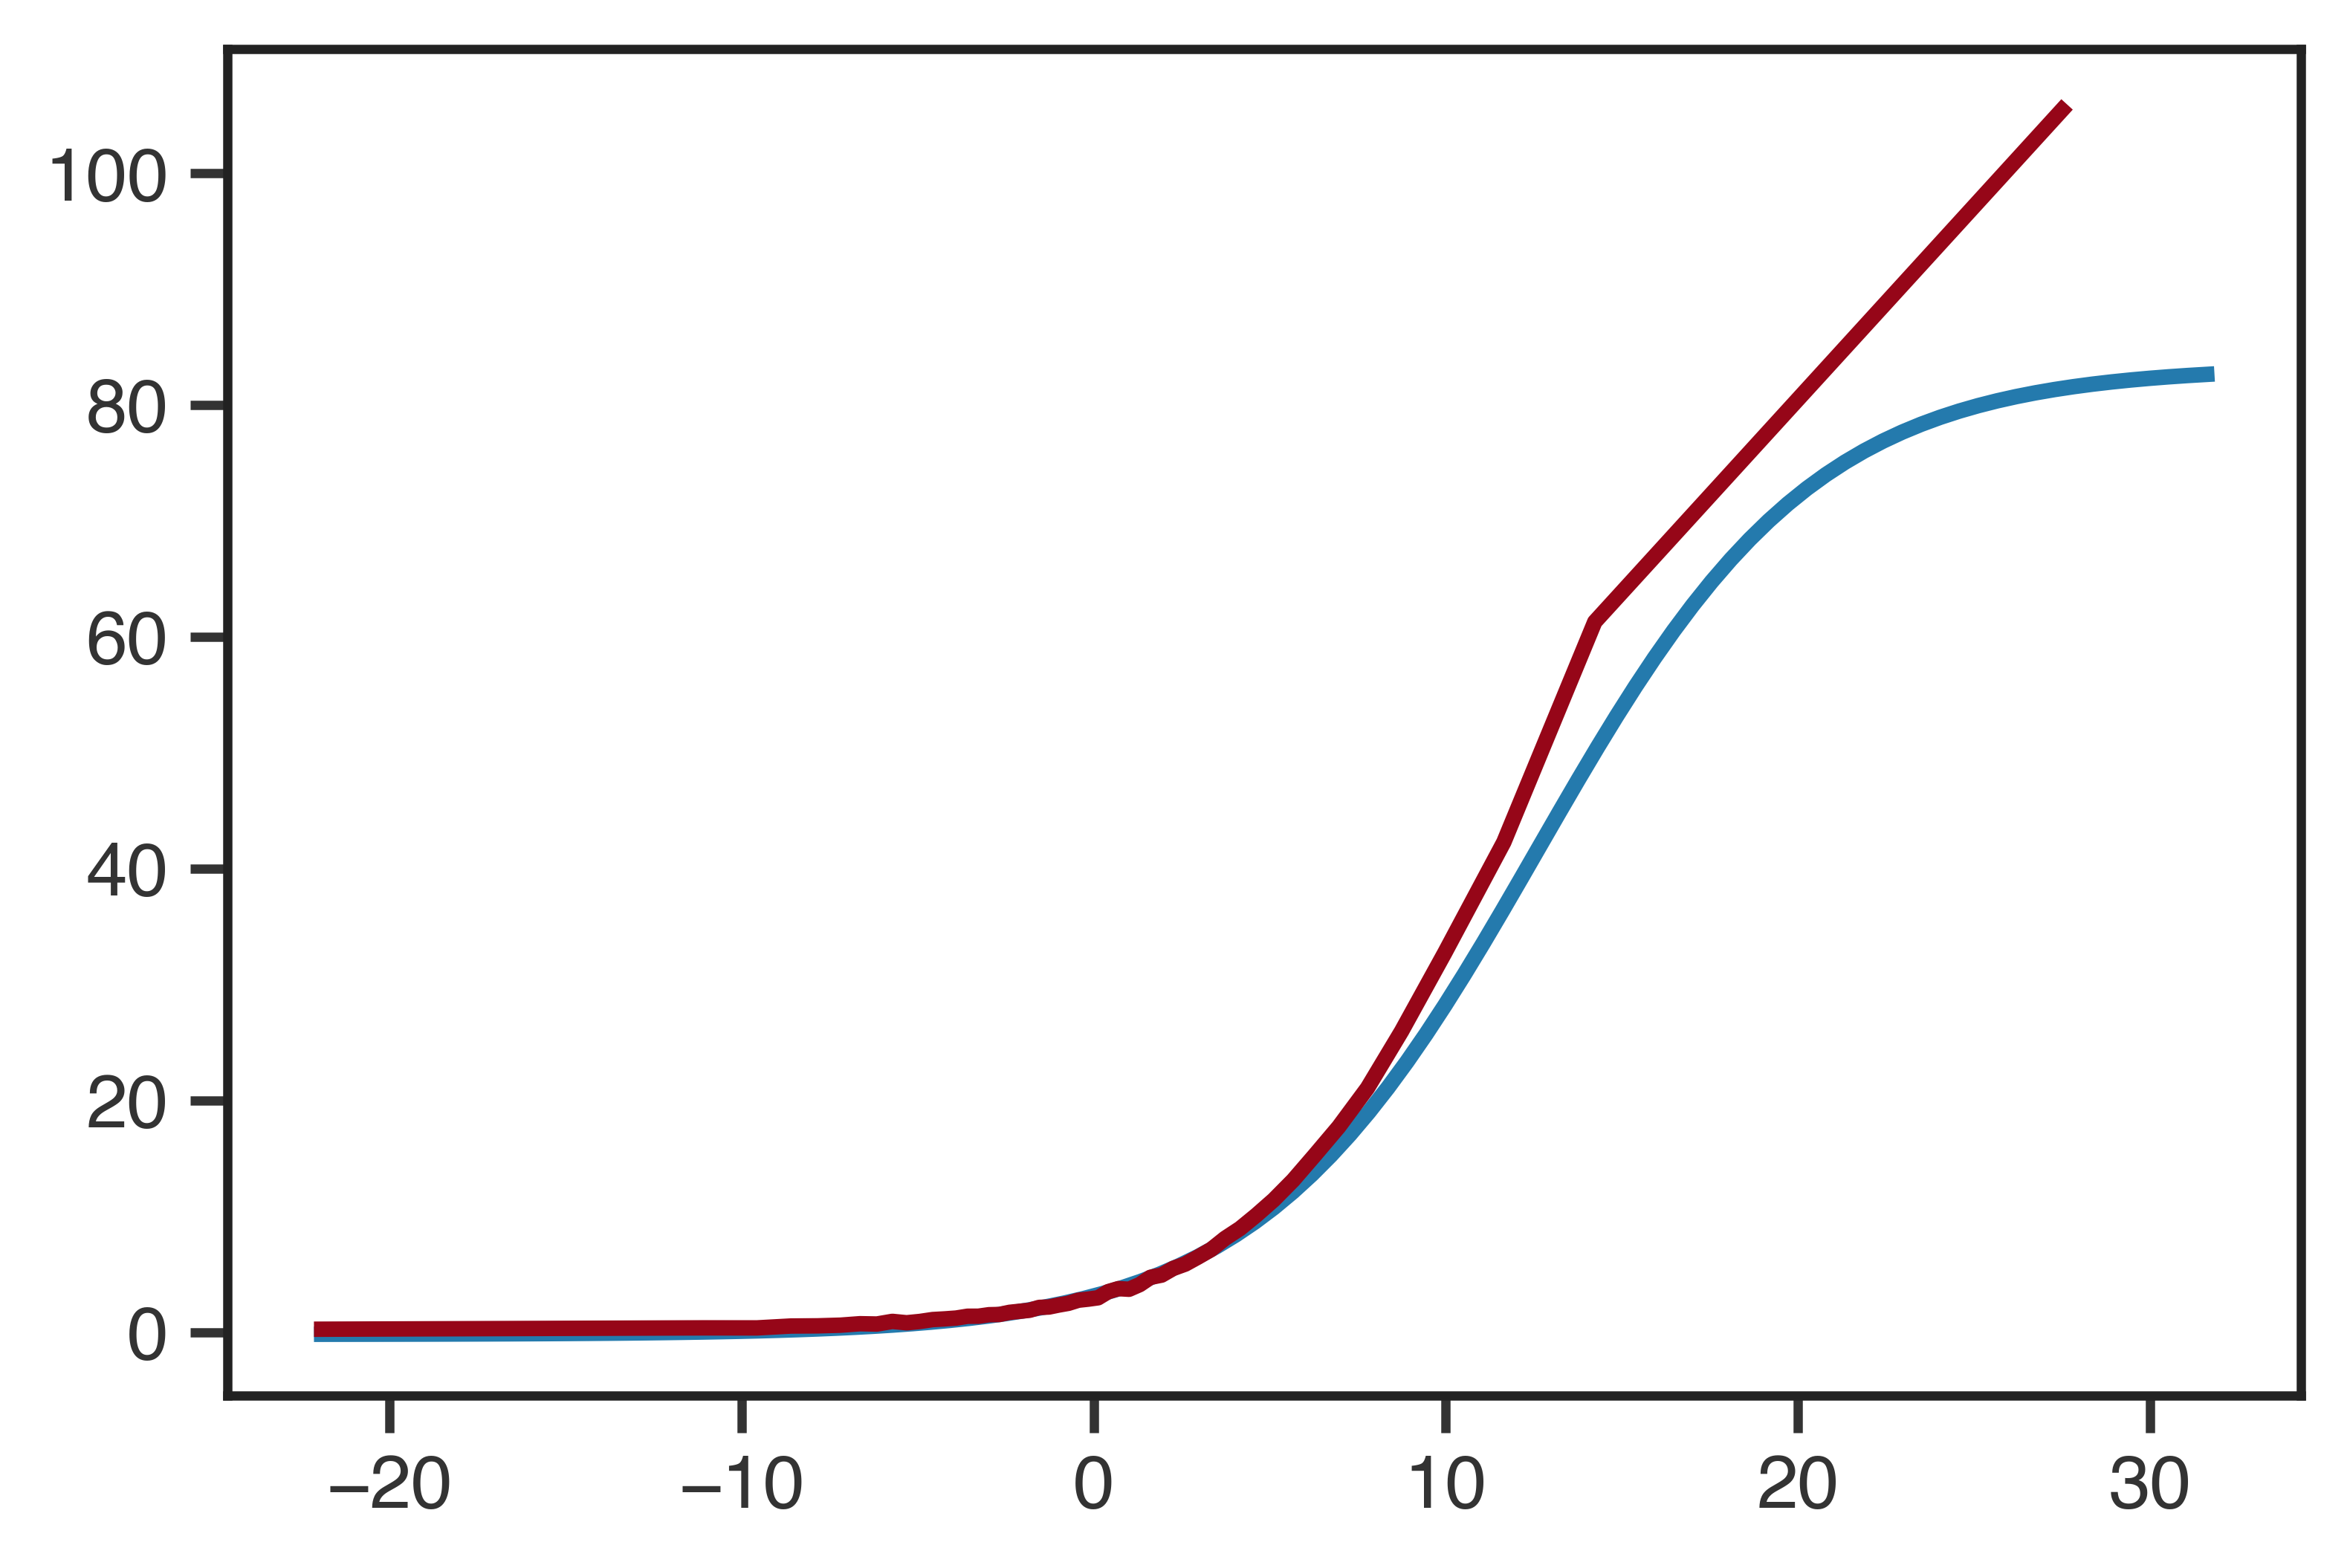

In [59]:
this_sigmoid.plot((pred.min(), pred.max()))
plt.plot(this_binterp.bins, this_binterp.values)

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


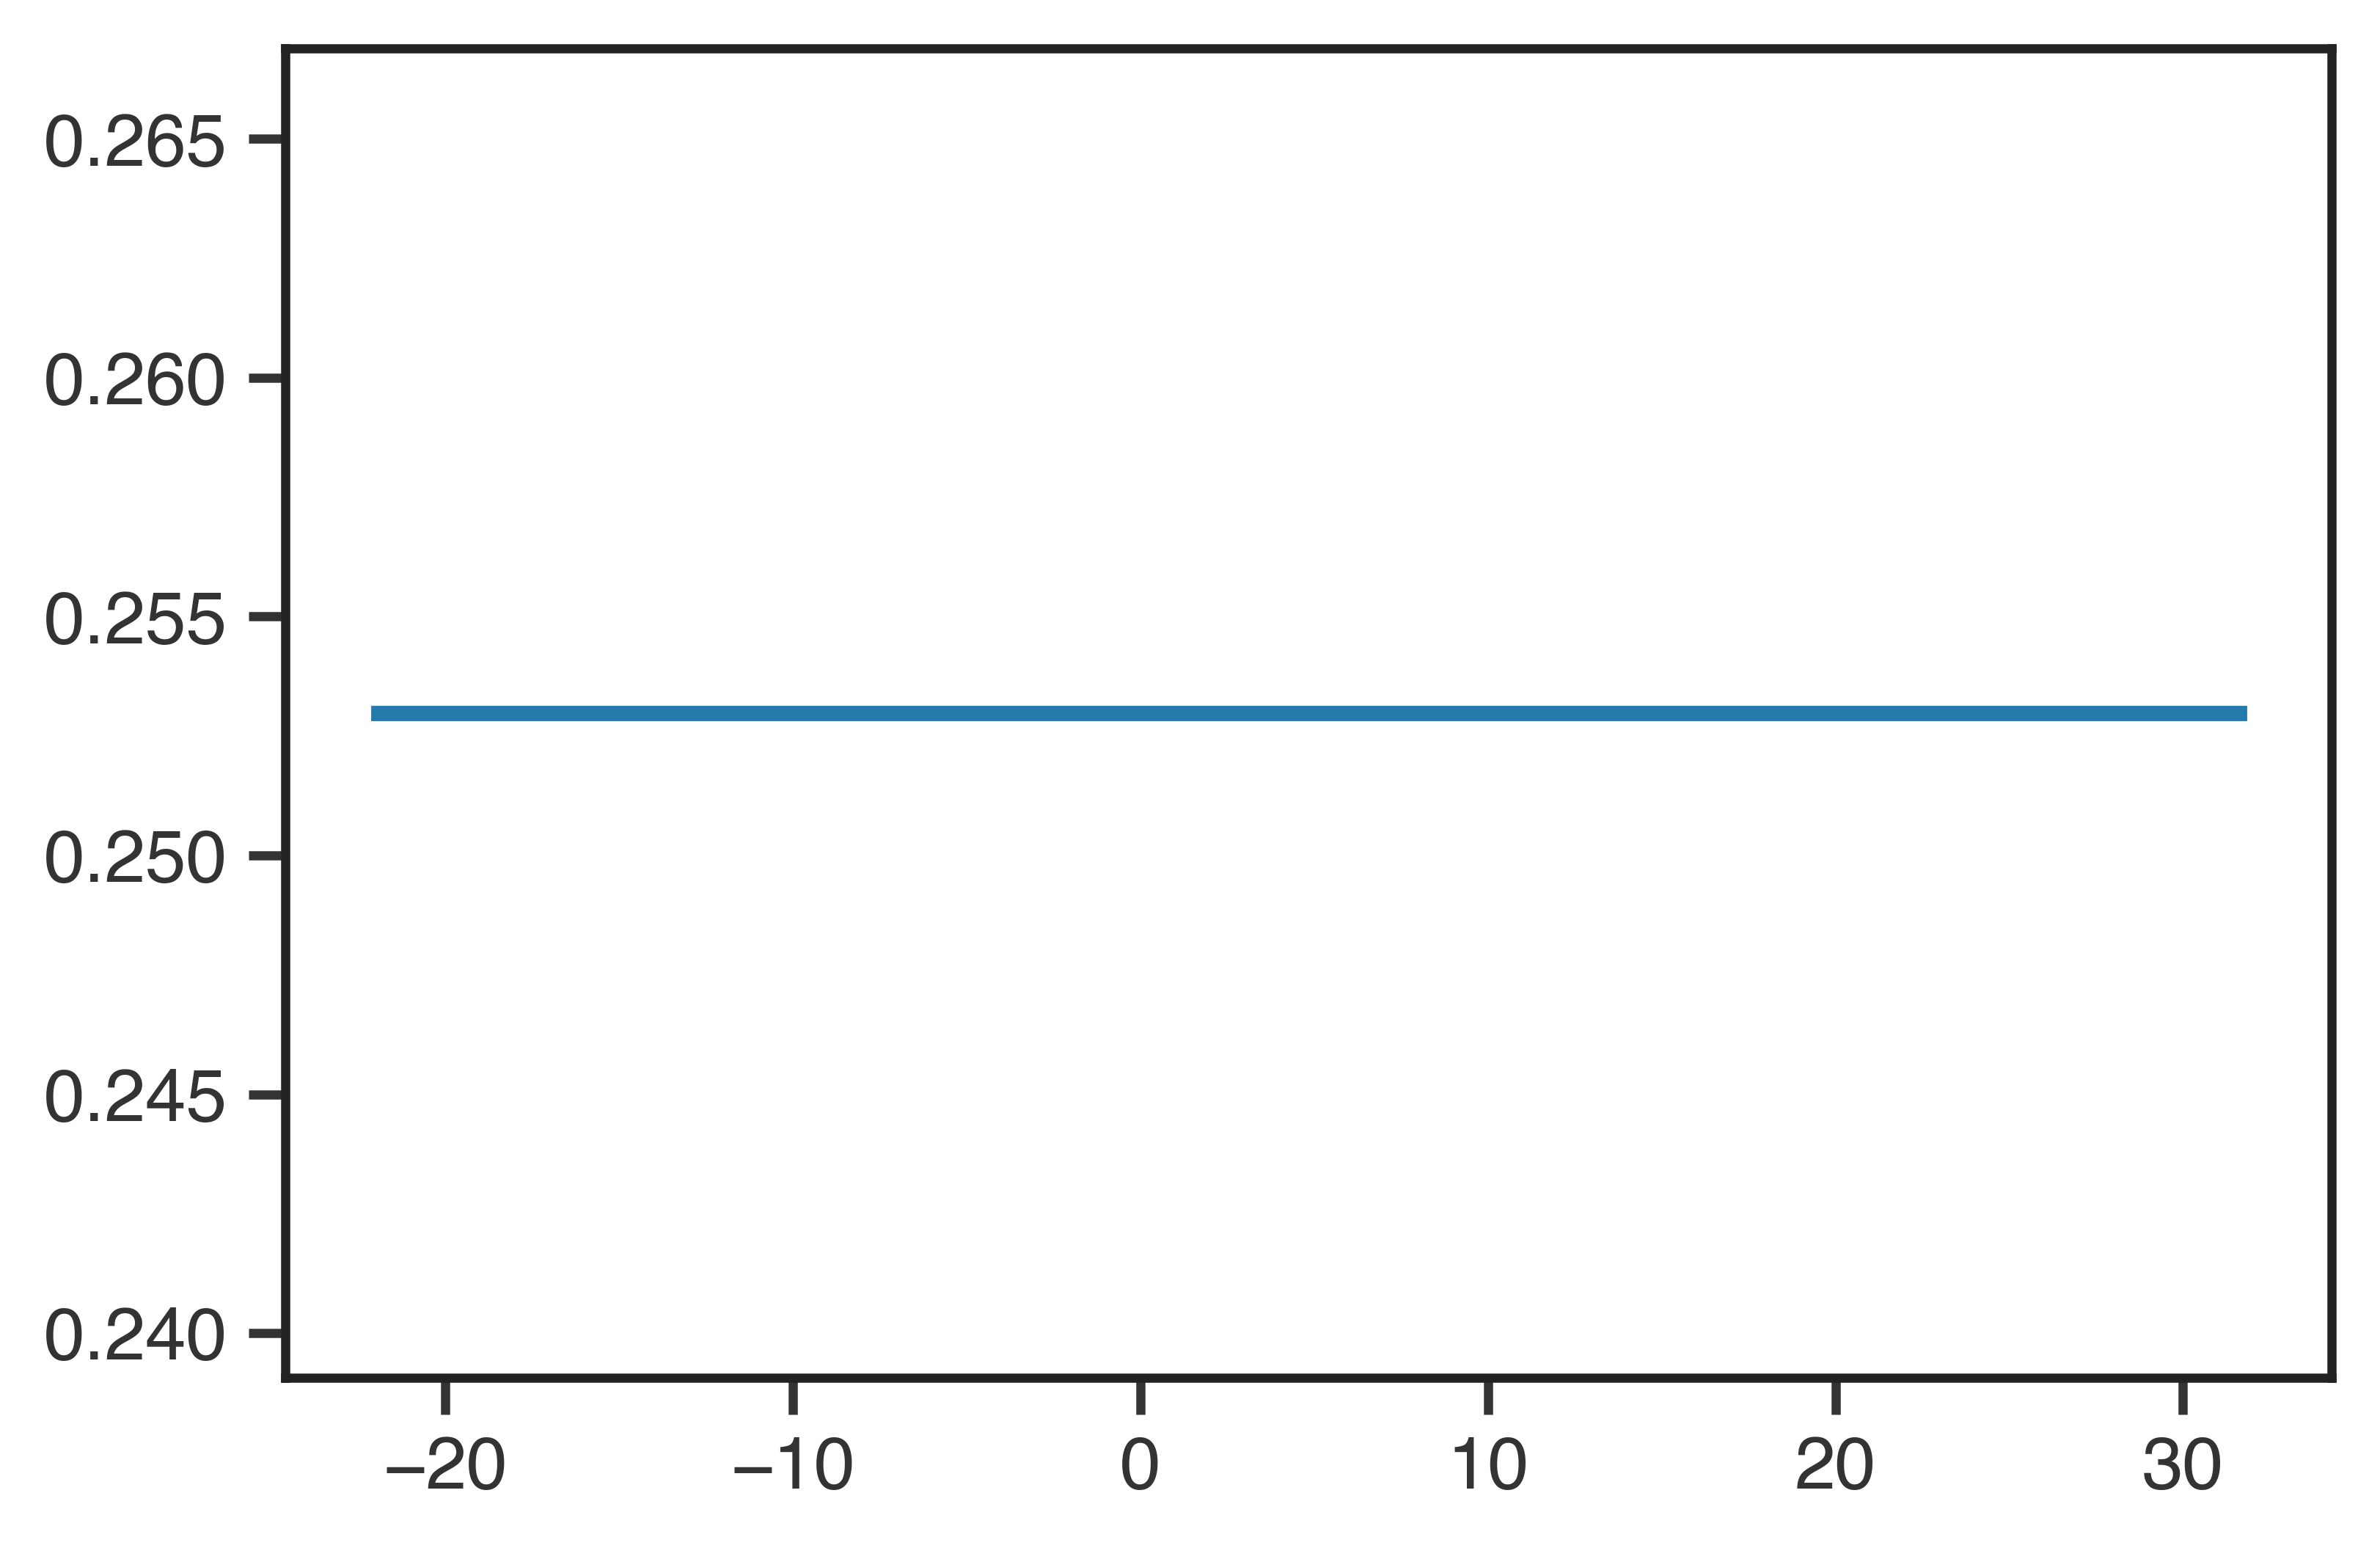

In [61]:
x = np.linspace(pred.min(), pred.max(), 100)
tmp_sigmoid = this_sigmoid.baseline + this_sigmoid.peak / (1 + np.exp(-this_sigmoid.slope * (x - this_sigmoid.threshold)))
plt.plot(x, tmp_sigmoid)

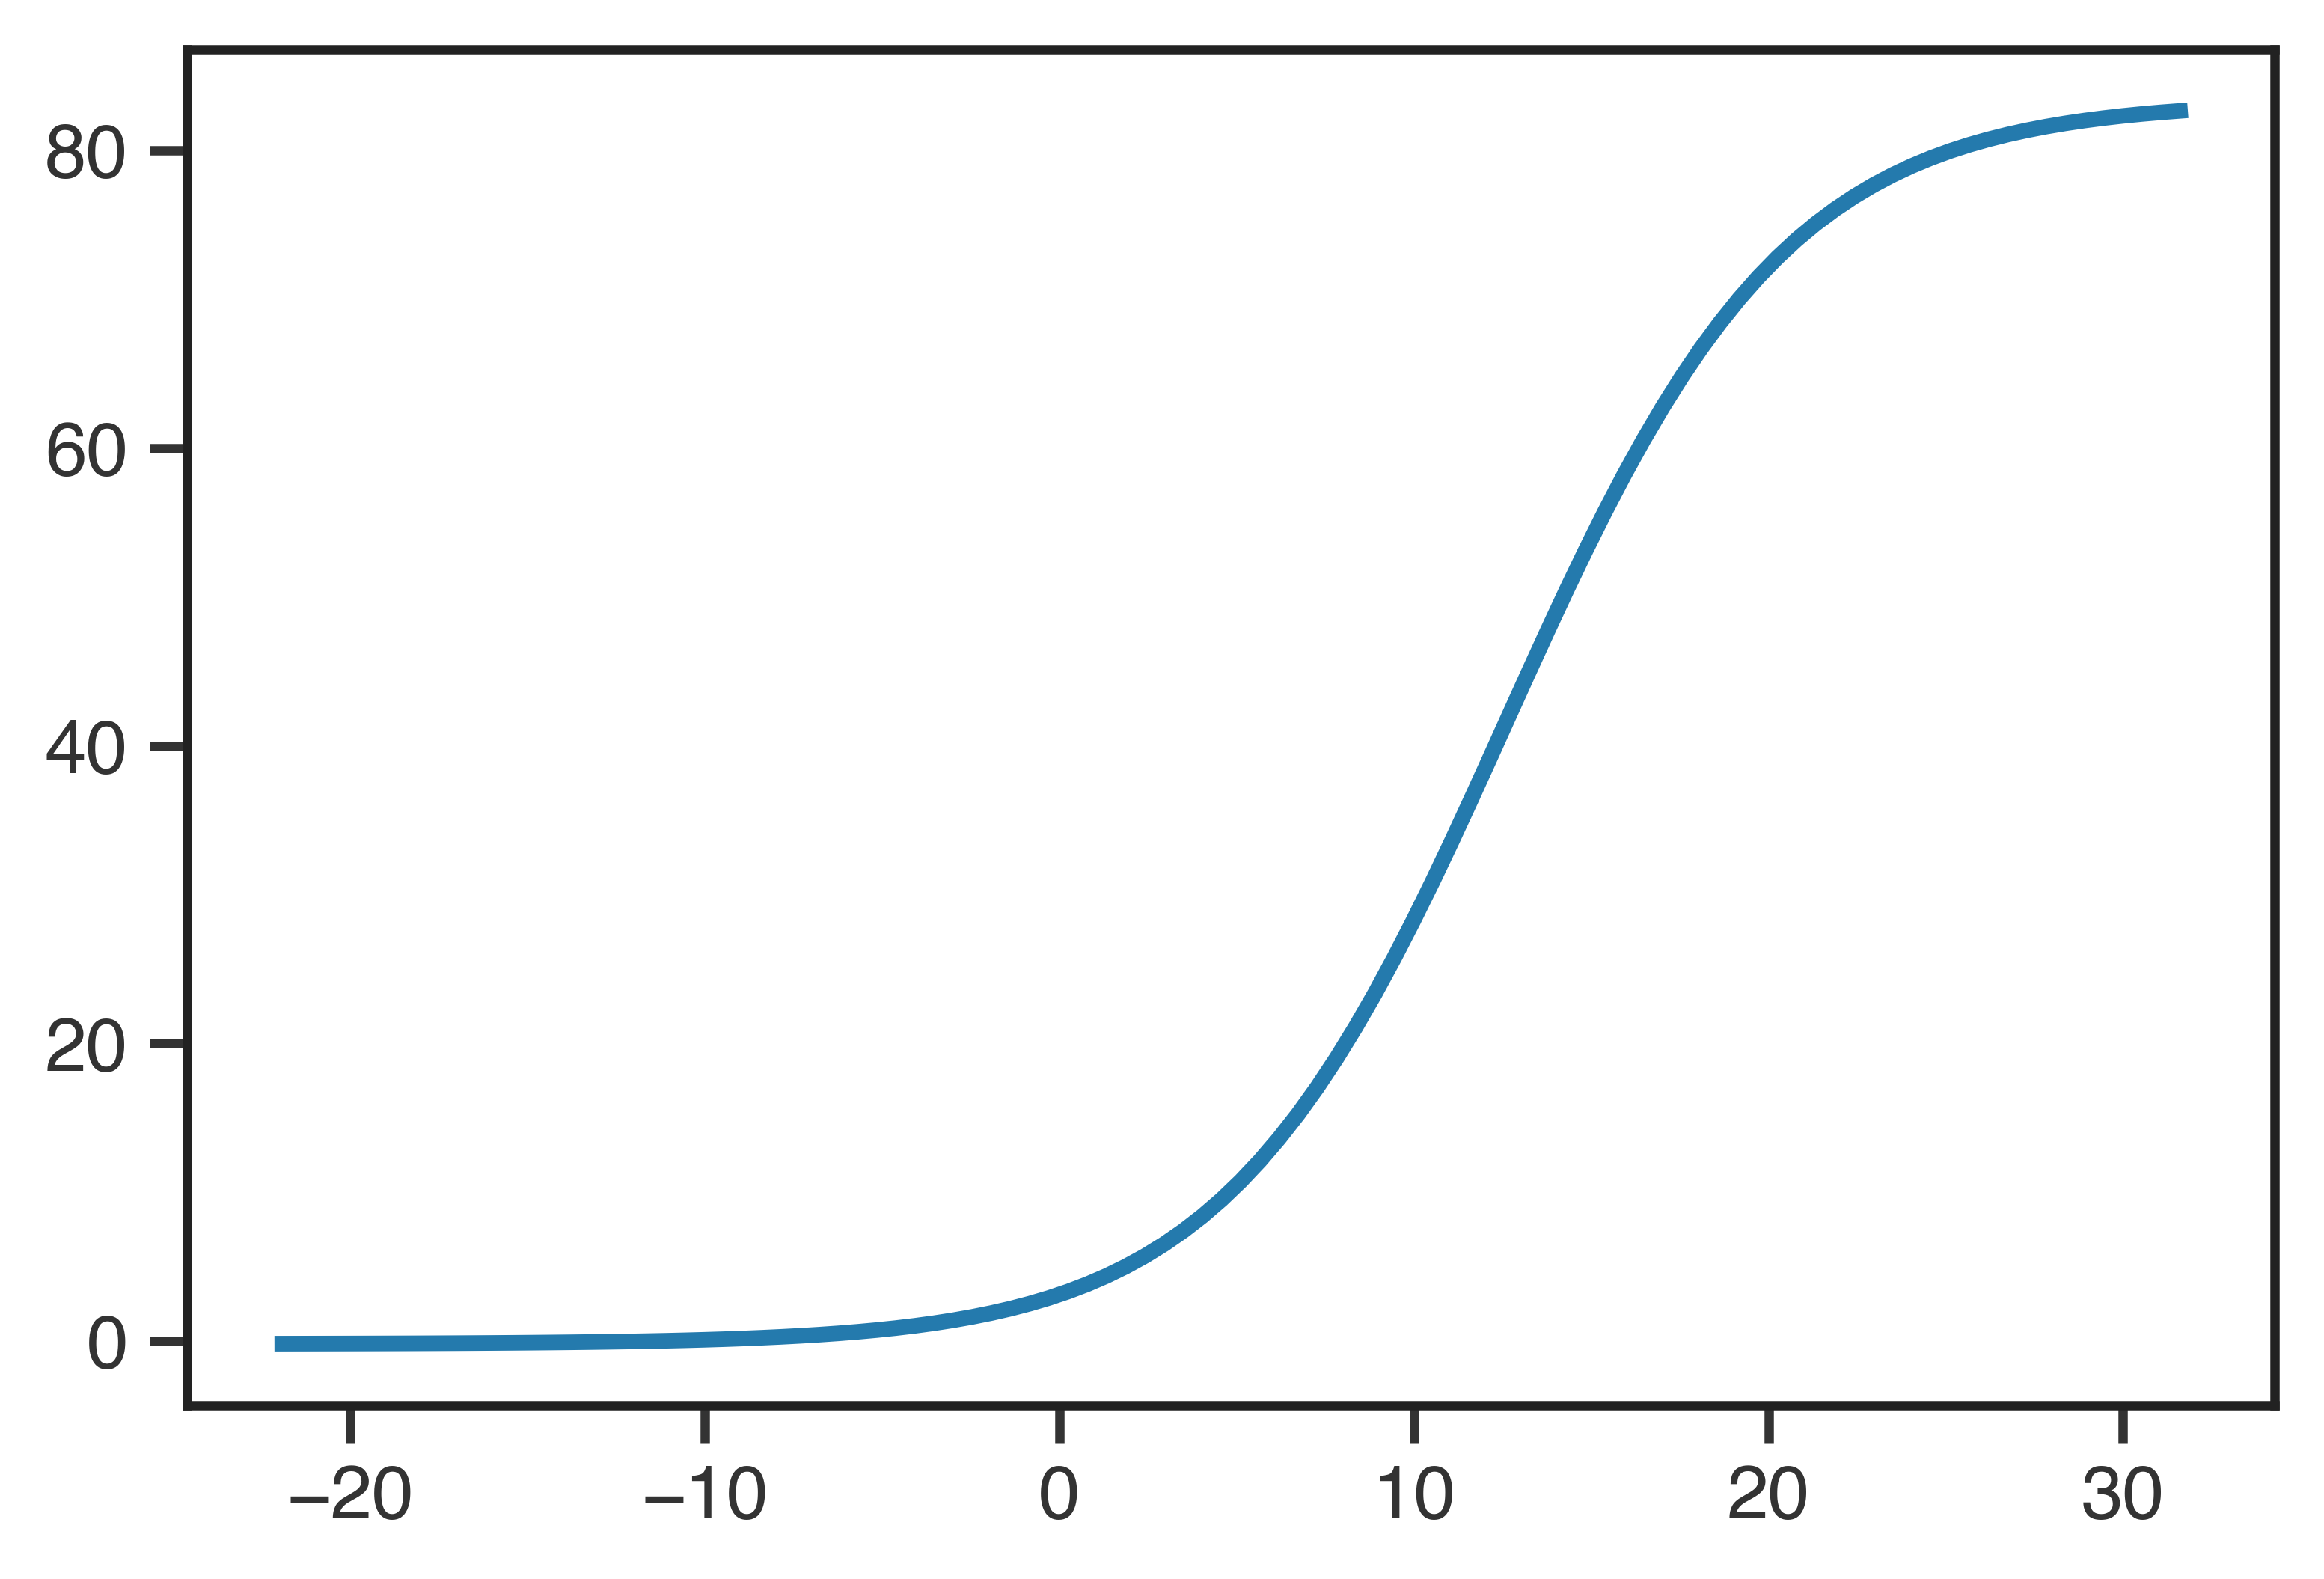

In [68]:
x = np.linspace(pred.min(), pred.max(), 100)
tmp_sigmoid = this_sigmoid.peak + this_sigmoid.threshold / (1 + np.exp(-this_sigmoid.baseline * (x - this_sigmoid.slope)))
plt.plot(x, tmp_sigmoid)
# this_sigmoid.plot((pred.min(), pred.max()))

In [60]:
? Sigmoid

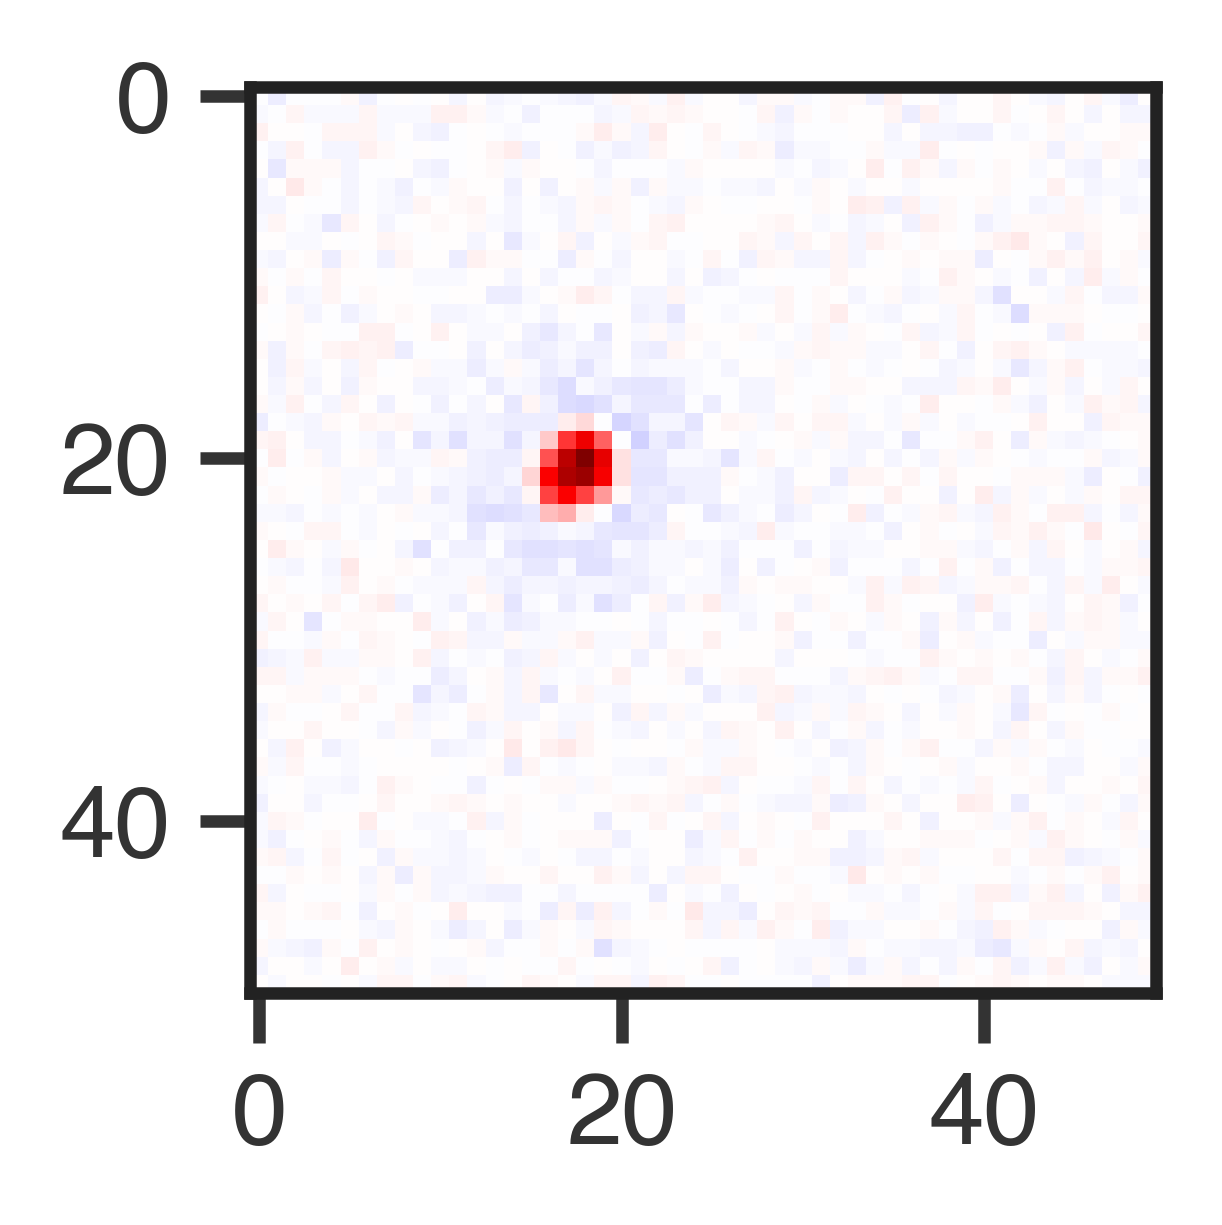

In [77]:
fig = plt.gcf()
fig.set_size_inches(2,2)
space, time = ft.decompose(all_stas['15-10-07'][0])
plt.imshow(space, cmap='seismic', clim=[-np.max(abs(space)), np.max(abs(space))])

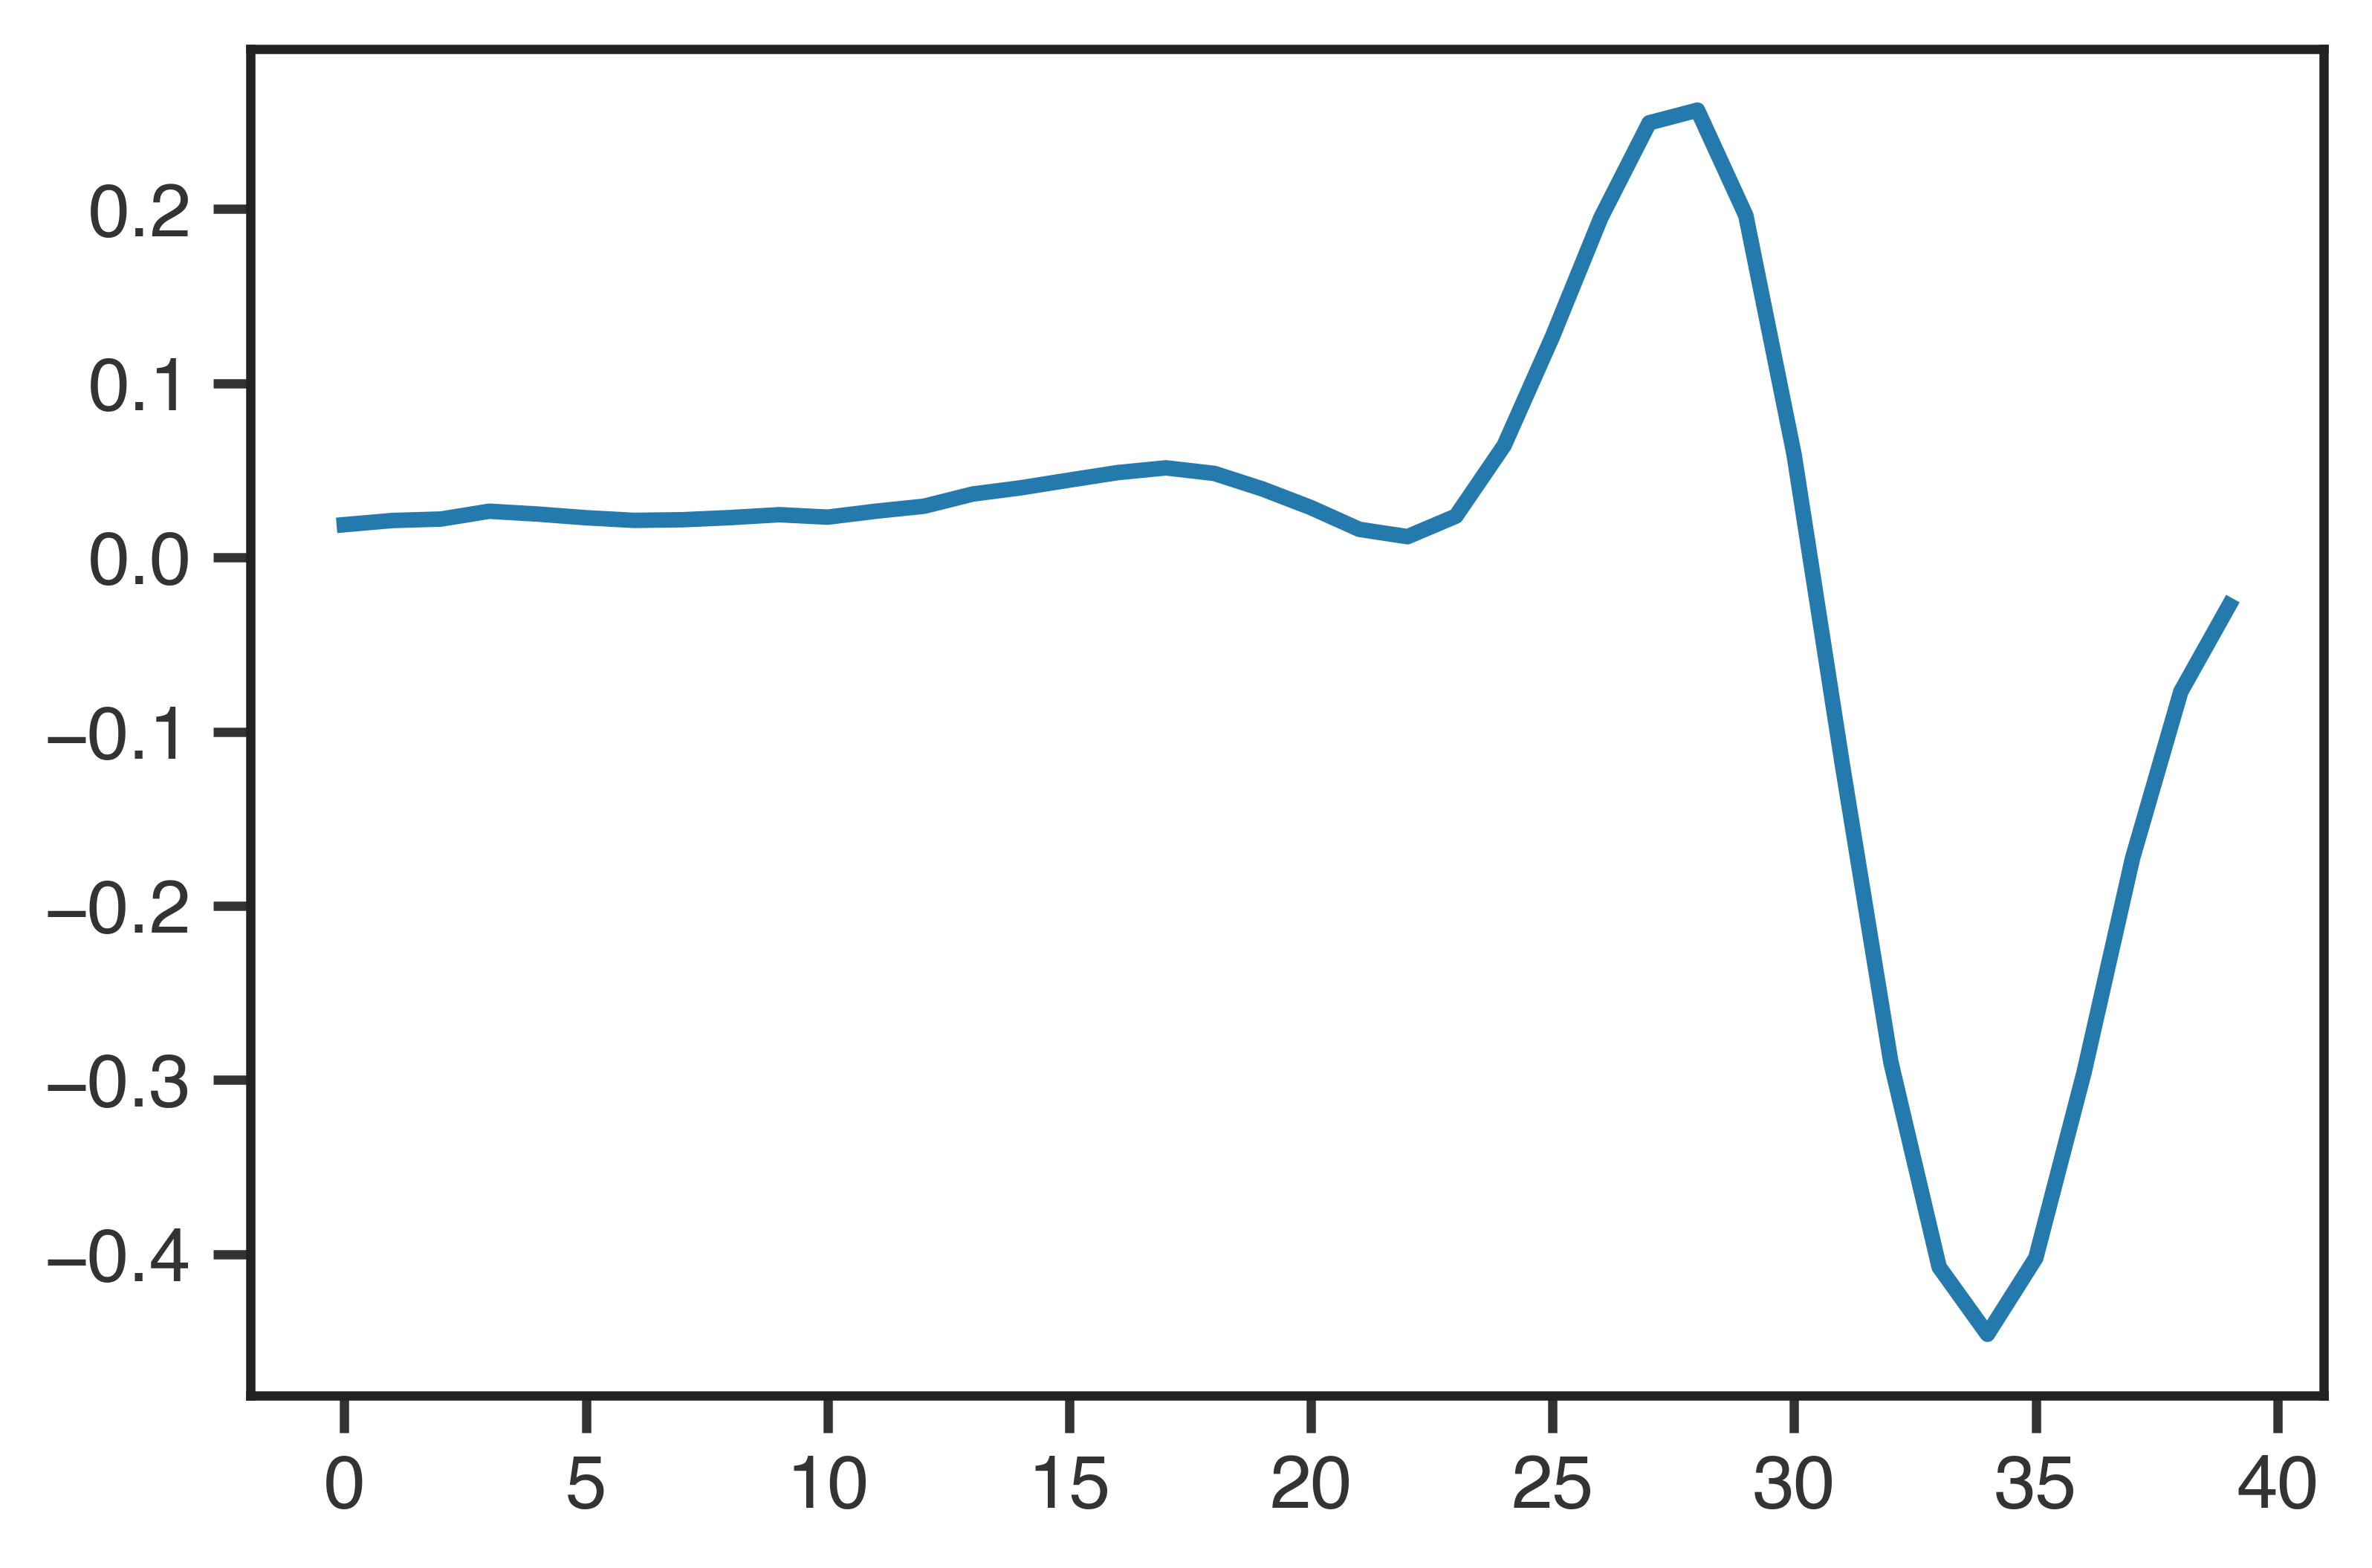

In [28]:
plt.plot(time)

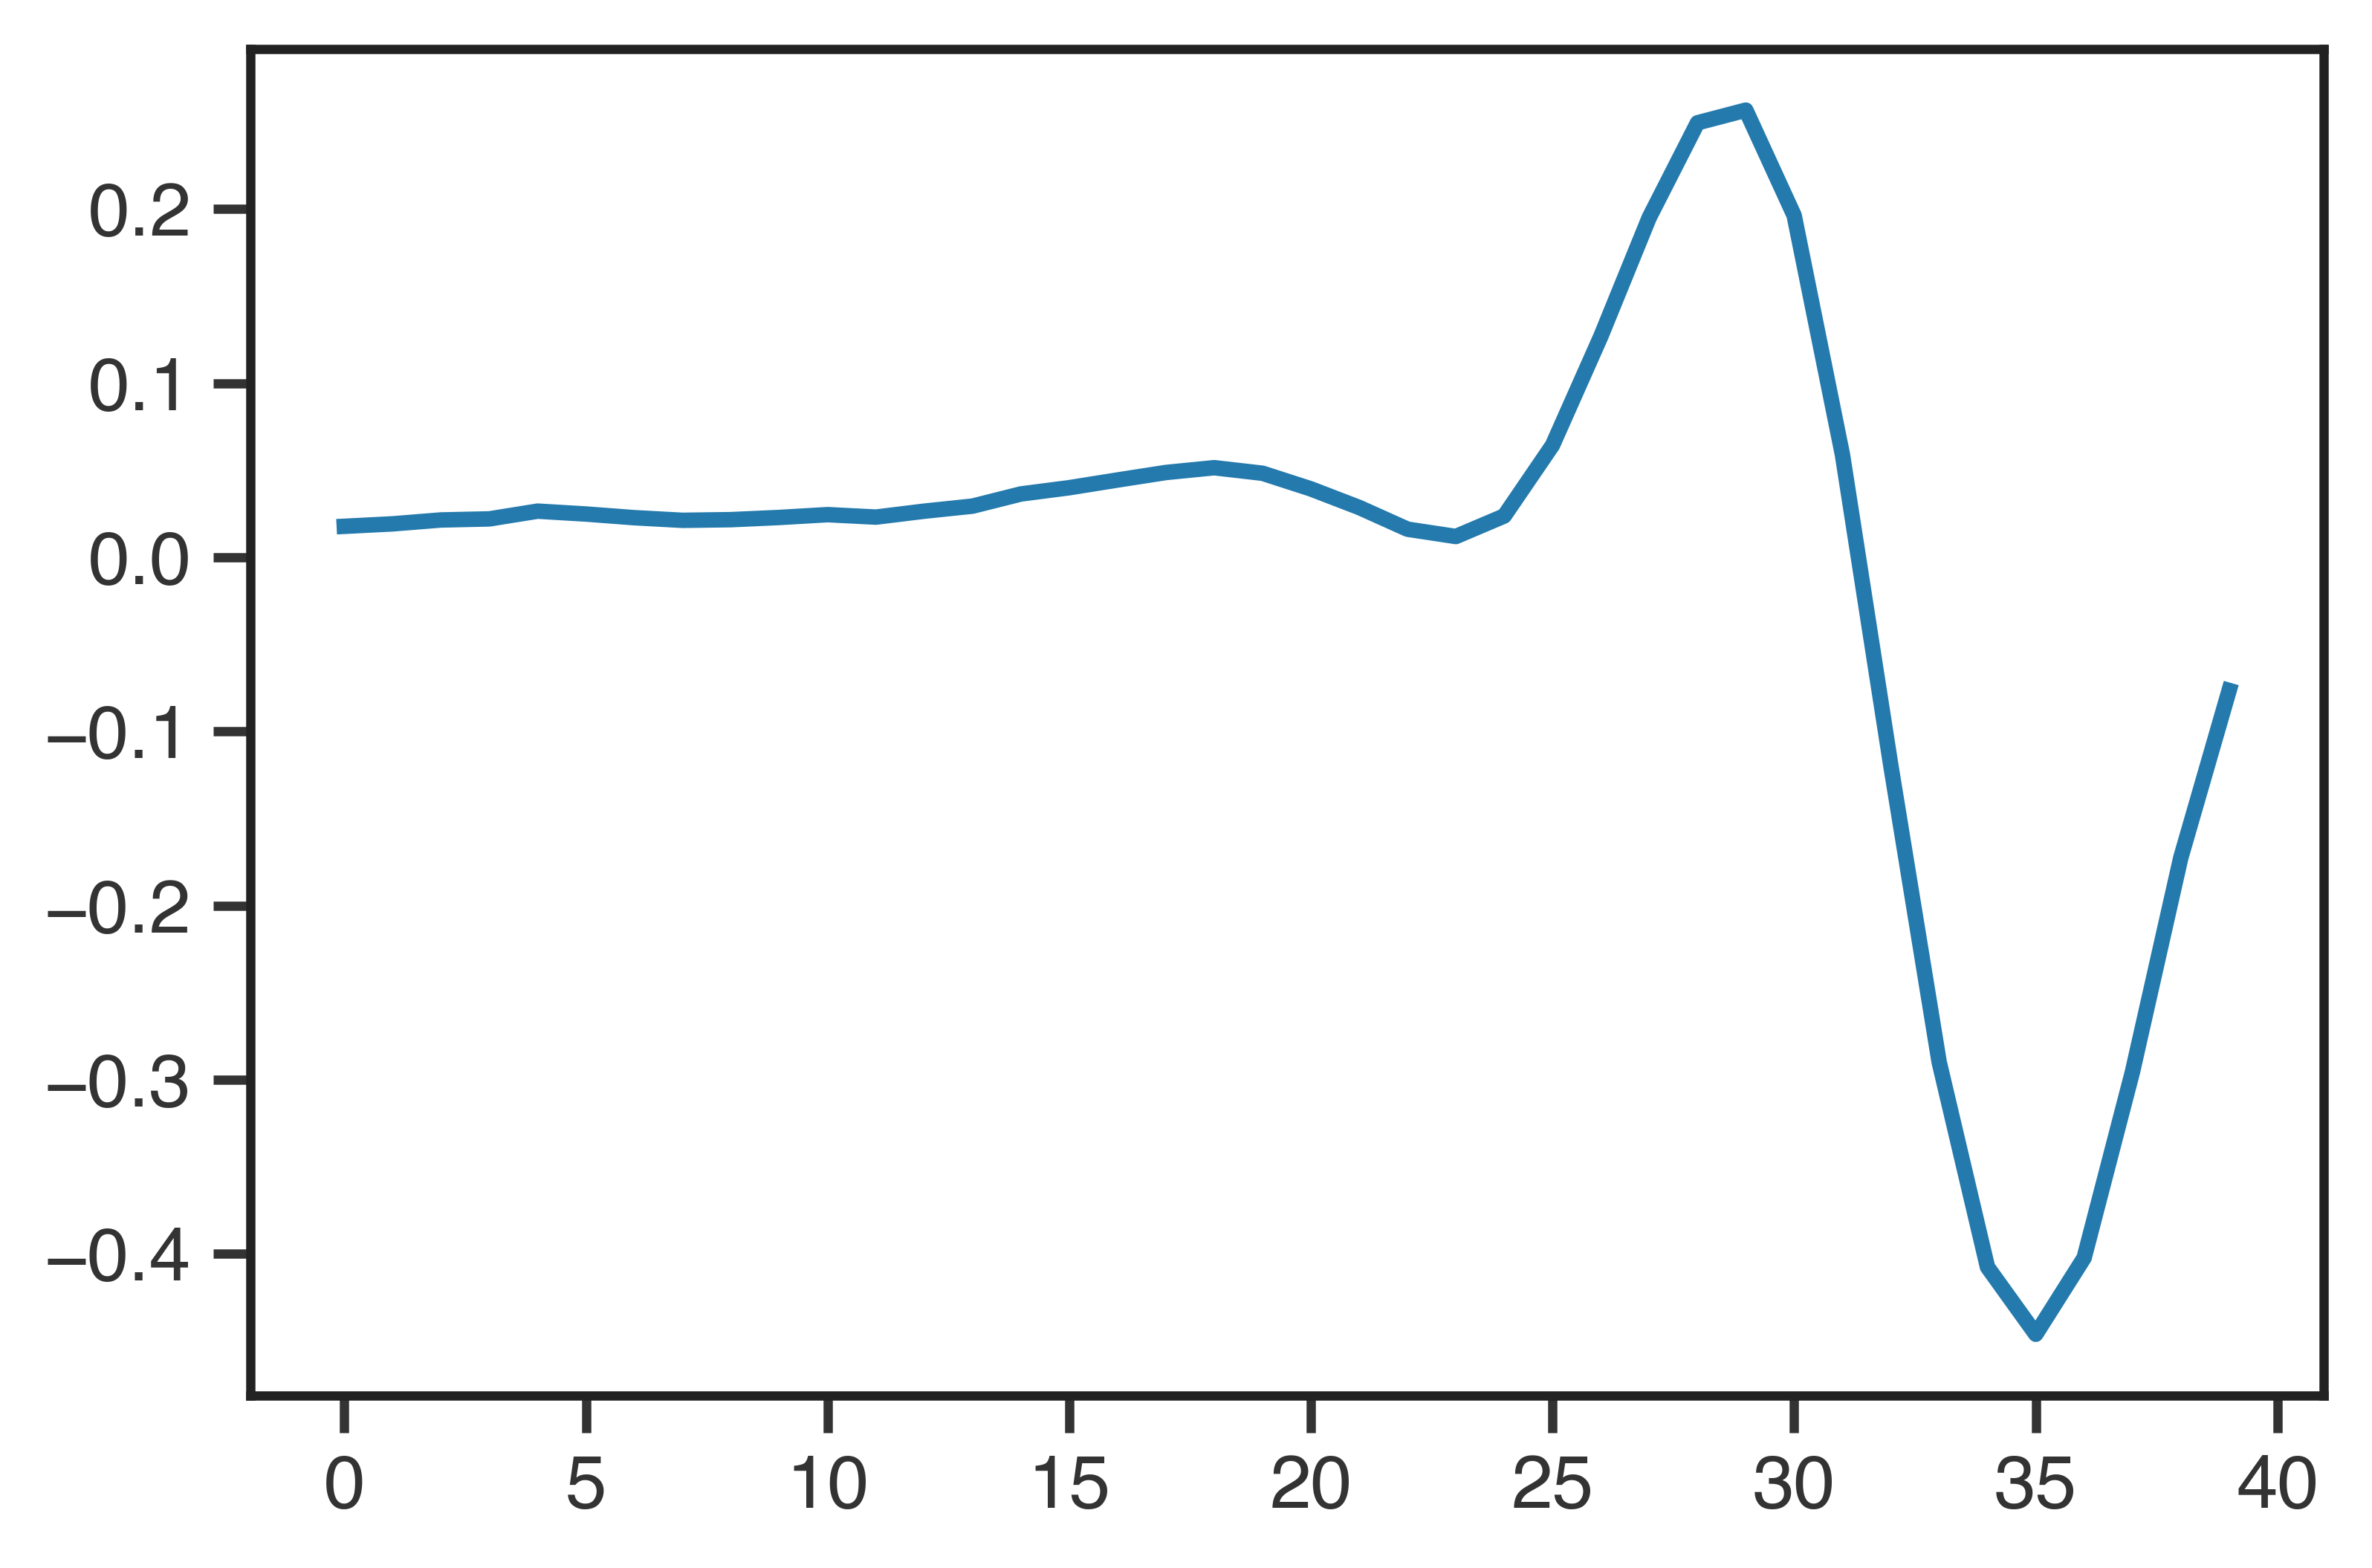

In [25]:
plt.plot(time)

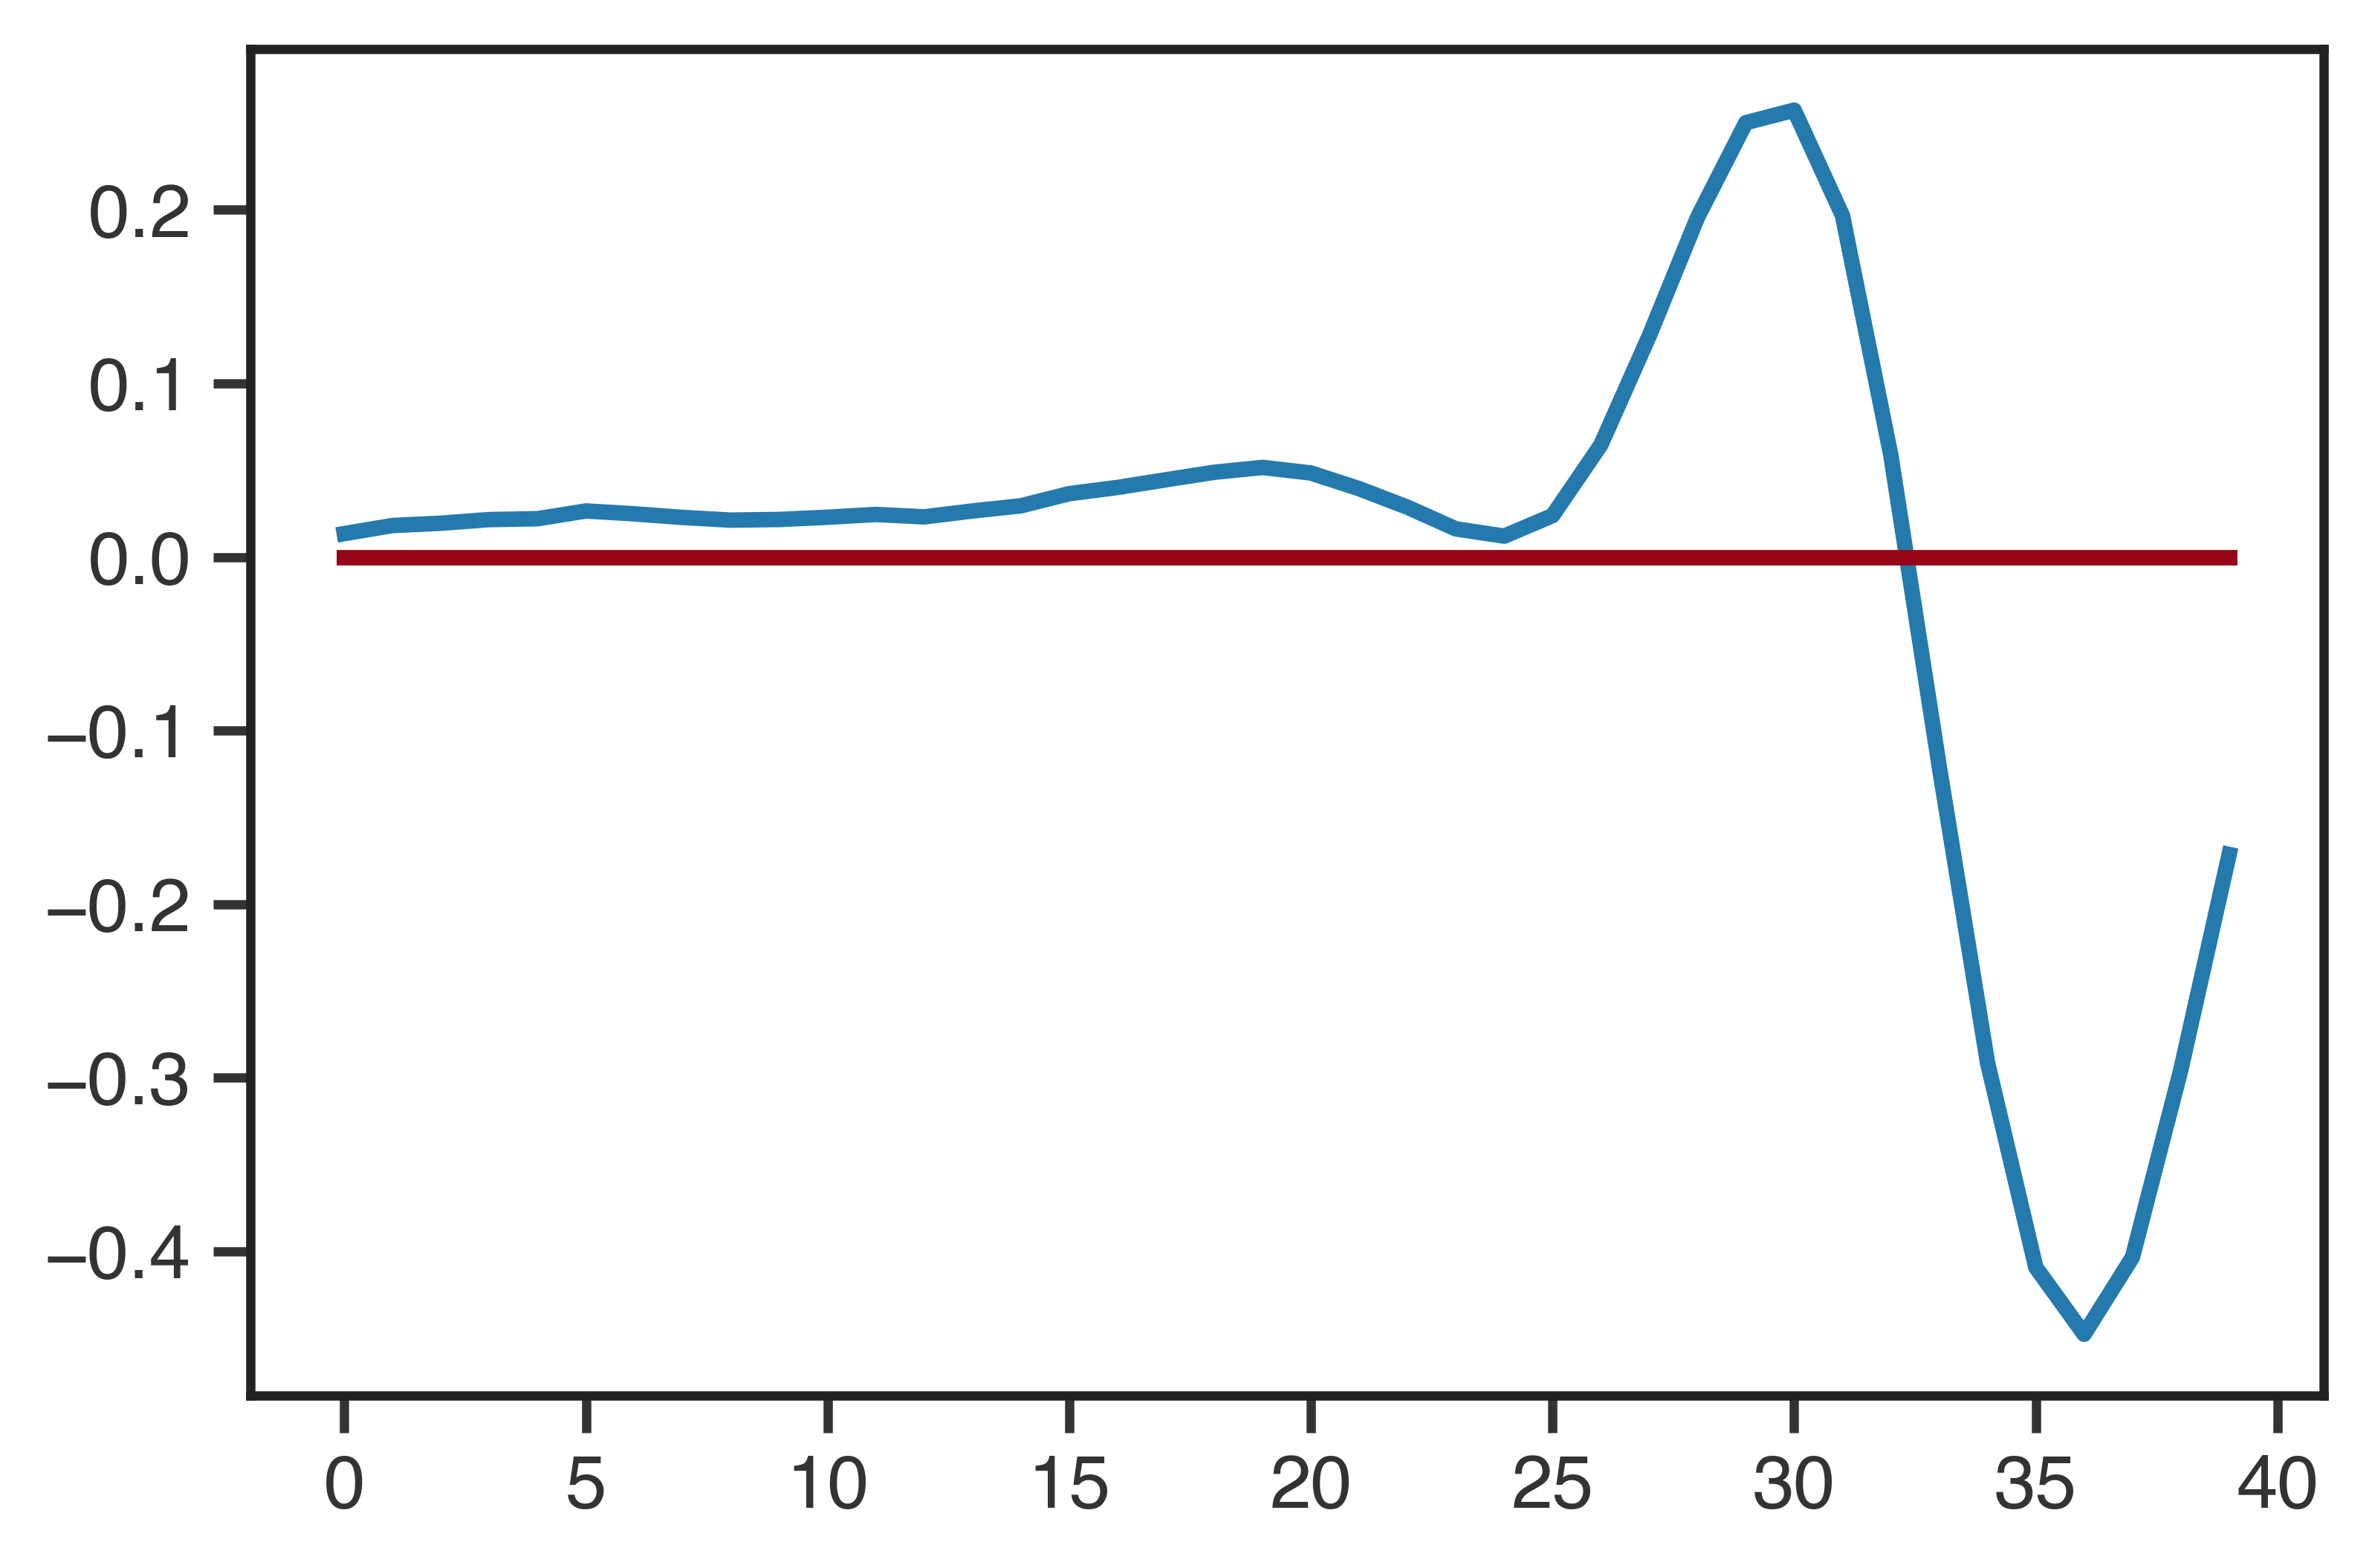

In [78]:
plt.plot(time)
plt.plot(np.zeros((len(time),)))

# Look at distribution of thresholds

In [5]:
import csv

In [15]:
celltypes = collections.defaultdict(list)
thresholds = collections.defaultdict(list)
noise = collections.defaultdict(list)
psth_noise = collections.defaultdict(list)
with open(expanduser('~/experiments/data/all-cells/all_cells.csv'), 'r') as csvfile:
    this_reader = csv.reader(csvfile)
    for row in this_reader:
        expt = row[2]
        cell_id = int(row[1][-2:]) - 1
        avg_stability = float(row[3])
        psth_stability = float(row[4])
        celltype = row[-1]
        celltypes[expt].append(celltype)
        noise[celltype].append(avg_stability)
        psth_noise[celltype].append(psth_stability)
        thresholds[celltype].append(all_thresholds[expt][cell_id])

In [16]:
noise['fastOFF']

[0.724168207,
 0.435377476,
 0.343625589,
 0.76461274,
 0.095912175,
 0.095912175,
 0.095912175,
 0.095912175,
 0.095912175,
 0.095912175,
 0.095912175,
 0.095912175,
 0.095912175]

<Container object of 40 artists>

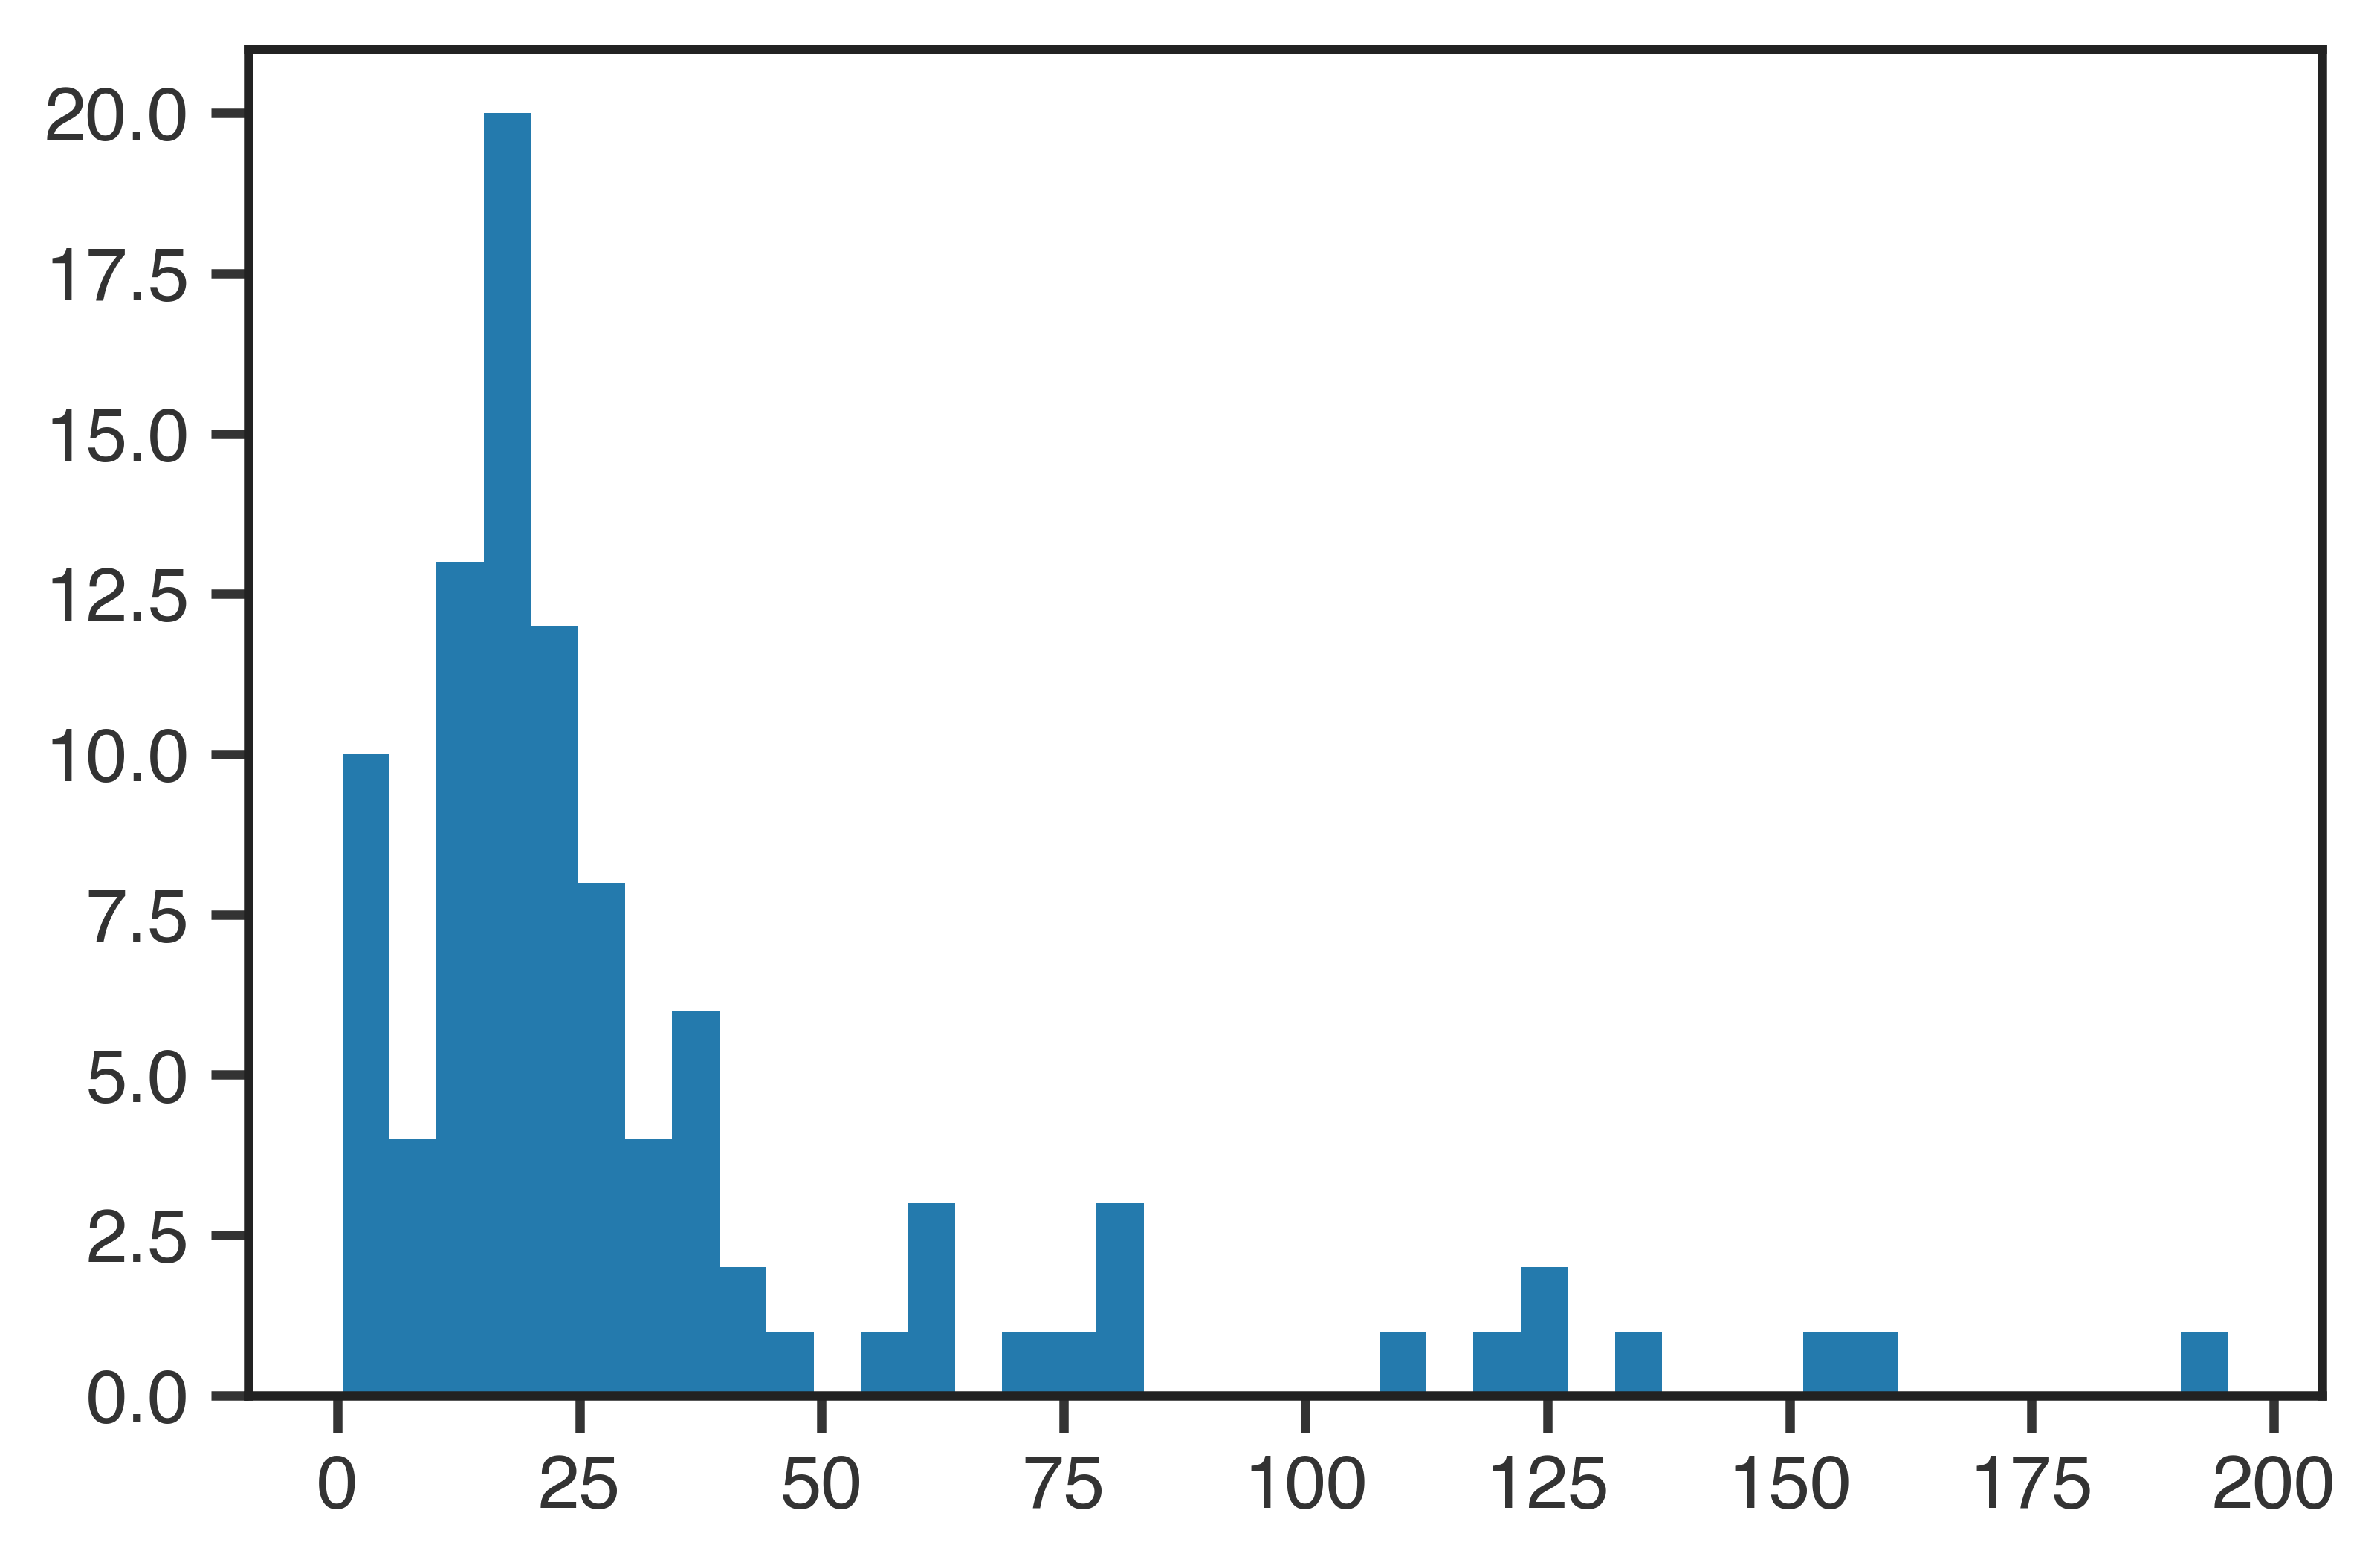

In [10]:
flat_thresholds = np.hstack([all_thresholds[k] for k in all_thresholds.keys()])
count, bins = np.histogram(flat_thresholds, bins=40)
bin_width = np.mean(np.diff(bins))
plt.bar(bins[:-1] + bin_width/2., count, width=bin_width)

## Scatter plot of noise versus thresholds for each cell type

In [24]:
colorscheme = {}
for celltype in noise.keys():
    colorscheme[celltype] = np.random.rand(3)

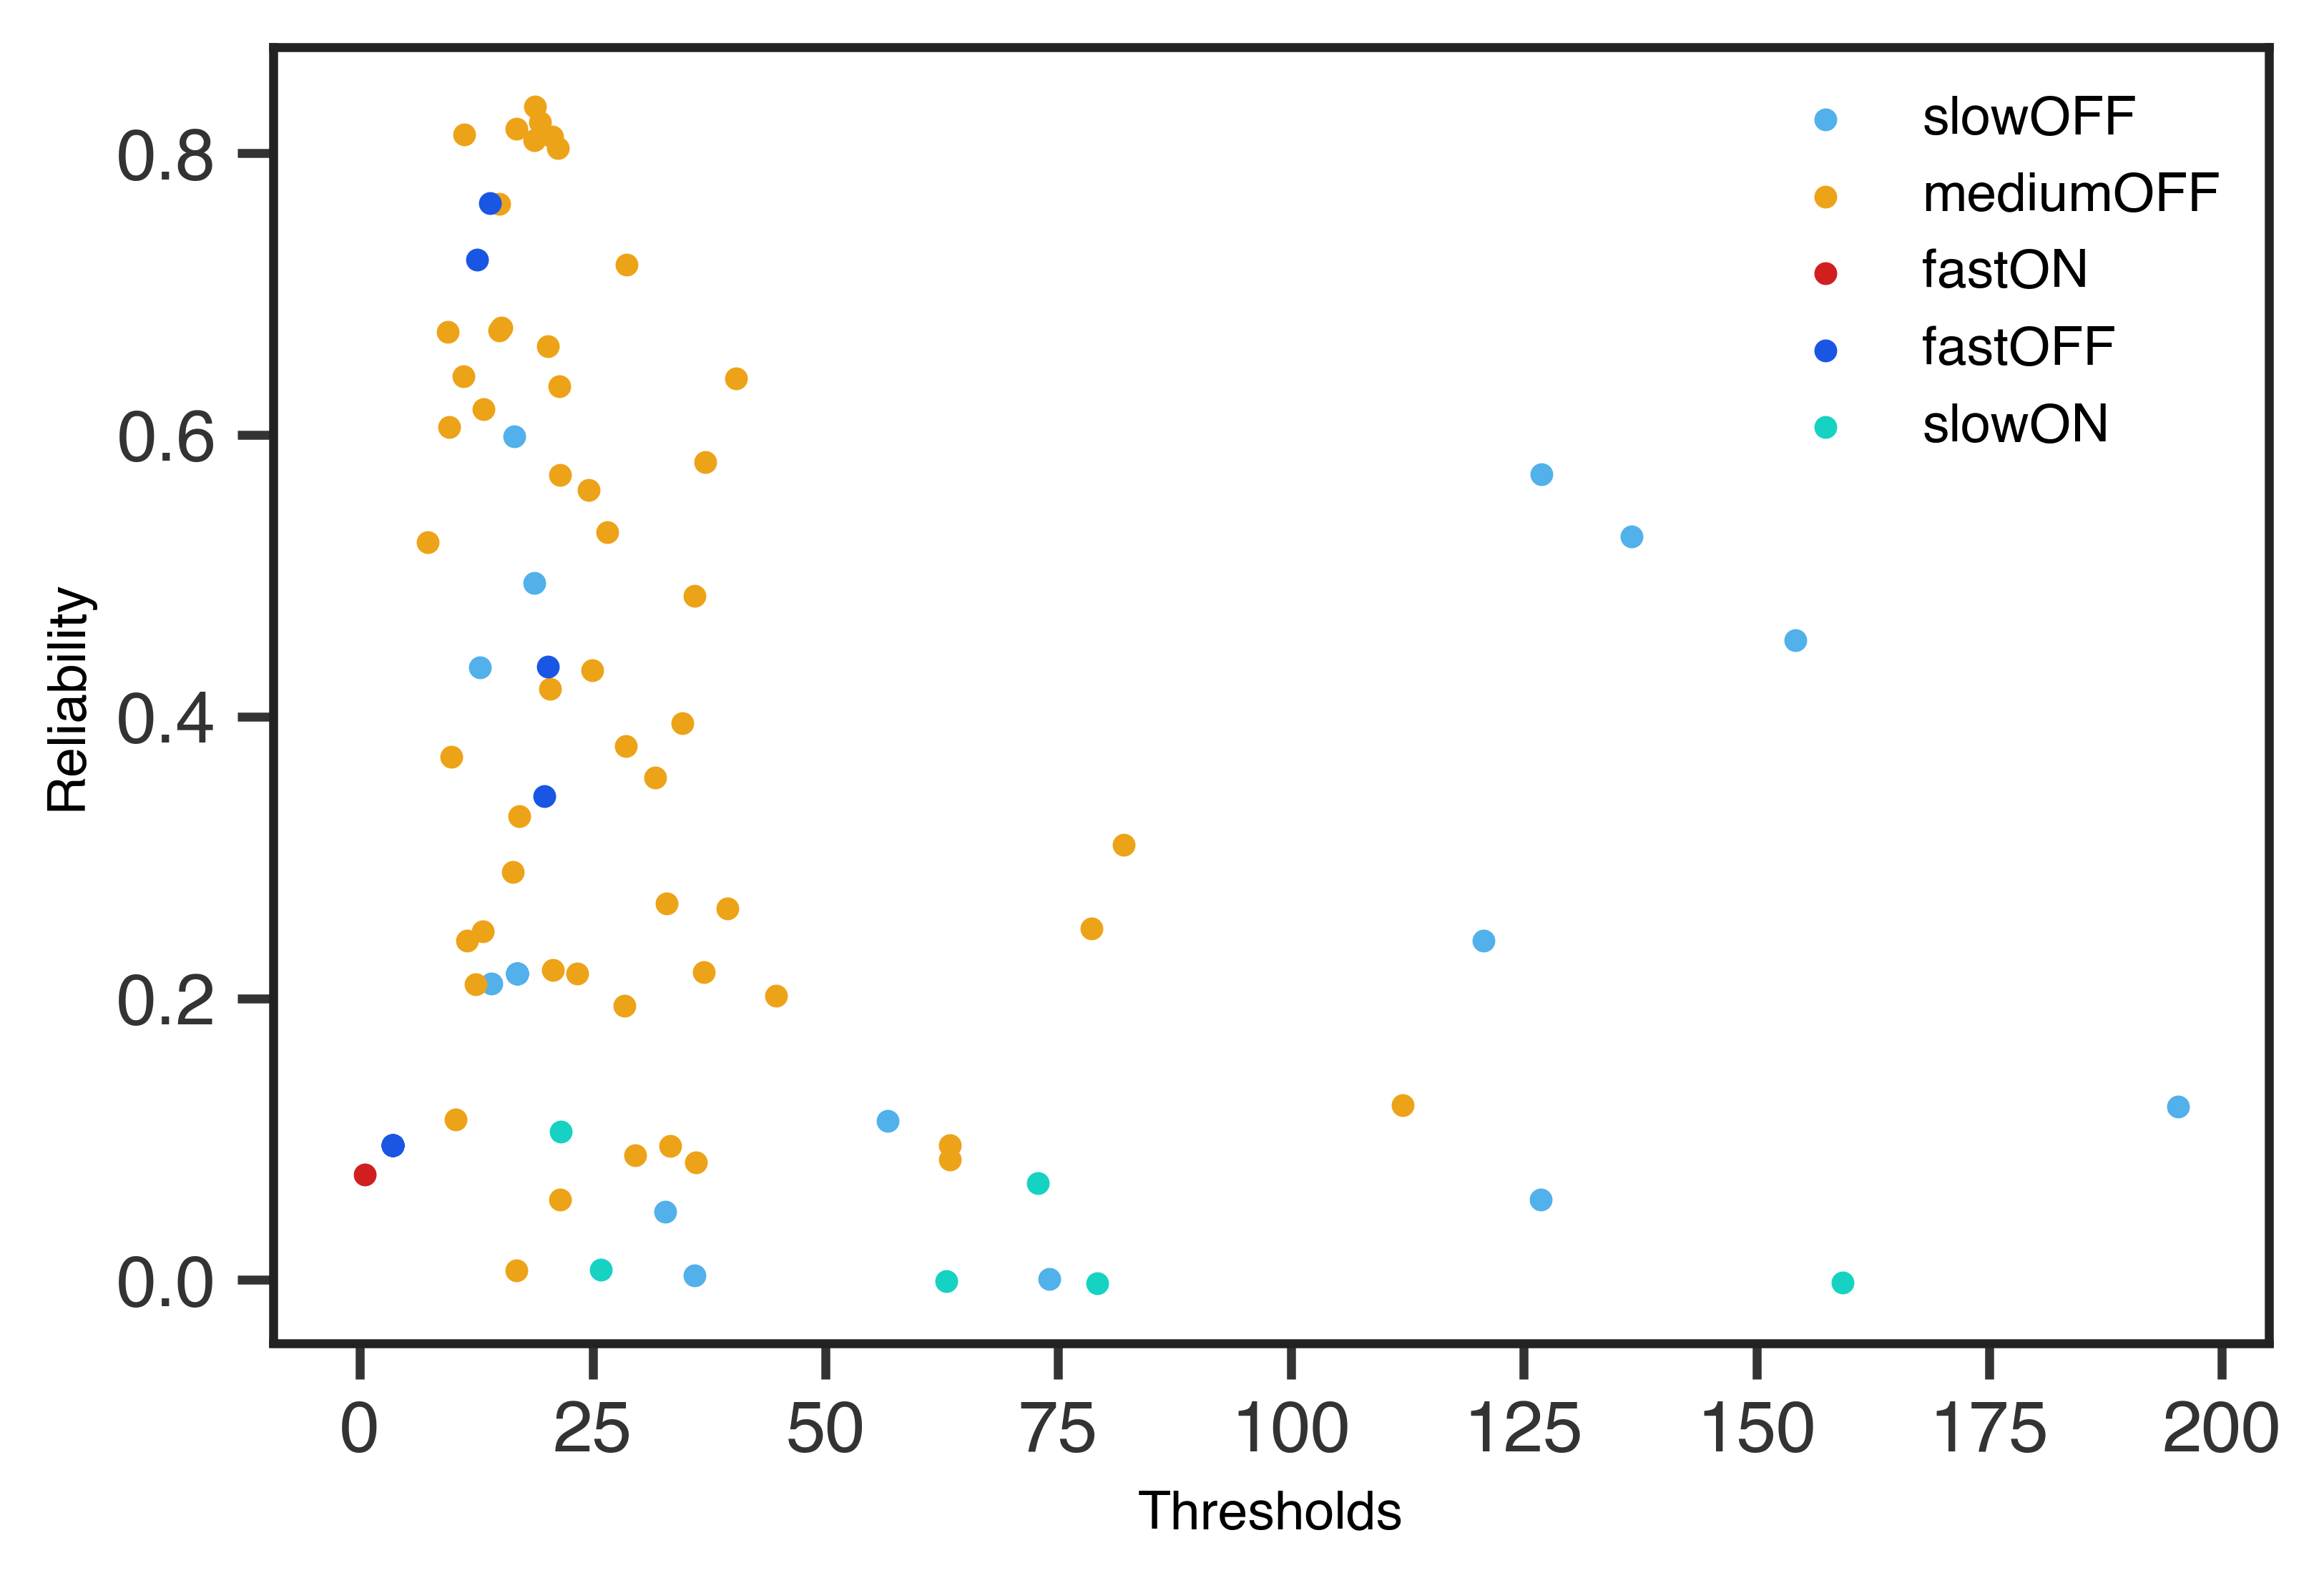

In [25]:
for celltype in noise.keys():
    plt.scatter(thresholds[celltype], noise[celltype], color=colorscheme[celltype], label=celltype, s=8)
    
plt.legend(frameon=False, fontsize=9, loc='upper right')
plt.xlabel('Thresholds', fontsize=9)
plt.ylabel('Reliability', fontsize=9)

In [50]:
sem_reliability = []
mean_reliability = []
celltype_ordering = []
for celltype in noise.keys():
    print(celltype + ' %0.2f reliability, %d threshold' %(np.nanmean(np.unique(noise[celltype])),
                                                   np.nanmean(np.unique(thresholds[celltype]))))
    sem_reliability.append(sem(np.unique(noise[celltype])[~np.isnan(np.unique(noise[celltype]))]))
    mean_reliability.append(np.nanmean(np.unique(noise[celltype])))
    celltype_ordering.append(celltype)

slowOFF 0.27 reliability, 72 threshold
mediumOFF 0.43 reliability, 27 threshold
fastON 0.07 reliability, 0 threshold
fastOFF 0.47 reliability, 14 threshold
slowON 0.03 reliability, 70 threshold


/home/lane/.local/lib/python3.5/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/lane/.local/lib/python3.5/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [29]:
noise['fastOFF']

[0.724168207,
 0.435377476,
 0.343625589,
 0.76461274,
 0.095912175,
 0.095912175,
 0.095912175,
 0.095912175,
 0.095912175,
 0.095912175,
 0.095912175,
 0.095912175,
 0.095912175]

In [30]:
thresholds['fastOFF']

[12.595252361551966,
 20.196931924780646,
 19.804568182072476,
 13.982581717088964,
 3.5073802964336593,
 3.5073802964336593,
 3.5073802964336593,
 3.5073802964336593,
 3.5073802964336593,
 3.5073802964336593,
 3.5073802964336593,
 3.5073802964336593,
 3.5073802964336593]

In [31]:
fits = np.load('fits_3_23.npy').item()

In [32]:
fits.keys()

dict_keys(['fast_on', 'fast_off_sensitizing', 'fast_off_adapting', 'medium_off_adapting', 'ganglion', 'slow_off'])

In [43]:
sem_reliability

[0.056441213705225687,
 0.034831092749741561,
 nan,
 0.12419169429740315,
 0.018886658931548884]

In [46]:
mean_reliability

[0.27323572173333333,
 0.43091453583018863,
 0.074702194999999999,
 0.47273923740000001,
 0.029470073166666666]

In [51]:
celltype_ordering

['slowOFF', 'mediumOFF', 'fastON', 'fastOFF', 'slowON']

In [54]:
fit_ordering = ['slow_off', 'medium_off_adapting', 'fast_on', 'fast_off_adapting']
sem_cws = []
mean_cws = []
for celltype in fit_ordering:
    sem_cws.append(sem(fits[celltype][:,1]))
    mean_cws.append(np.mean(fits[celltype][:,1]))

In [62]:
sem_cws

[0.010753803507503205,
 0.0072188420536787598,
 0.017641840256621816,
 0.0024399399027014625]

#### Plot center weight versus noise

In [58]:
colorscheme = {
    'ganglion': 'k',
    'fast_off_sensitizing': 'r',
    'fast_off_adapting': 'g',
    'slow_off': 'y',
    'fast_on': 'b',
    'medium_off_adapting': 'c'
}

In [64]:
# from Notebook Surround - 4-4 Minimal lhs figures
ideal_cw = 0.53020134228187921

In [91]:
def exponential_fit(x, baseline, gain, offset):
#     baseline, gain, offset = p
    return baseline + np.exp(gain*(x - offset))

In [92]:
gain, baseline = np.polyfit(np.log(np.array(mean_cws)), mean_reliability[:-1], 1)
print((gain, baseline))

(-3.3041481439870157, -1.5157872697269816)


In [94]:
popt, pcov = curve_fit(exponential_fit, np.array(mean_reliability[:-1]), np.array(mean_cws), p0=(0.52, -.3, 0.1))
print(popt)

[ 0.53541541 -4.05196304 -0.53263576]


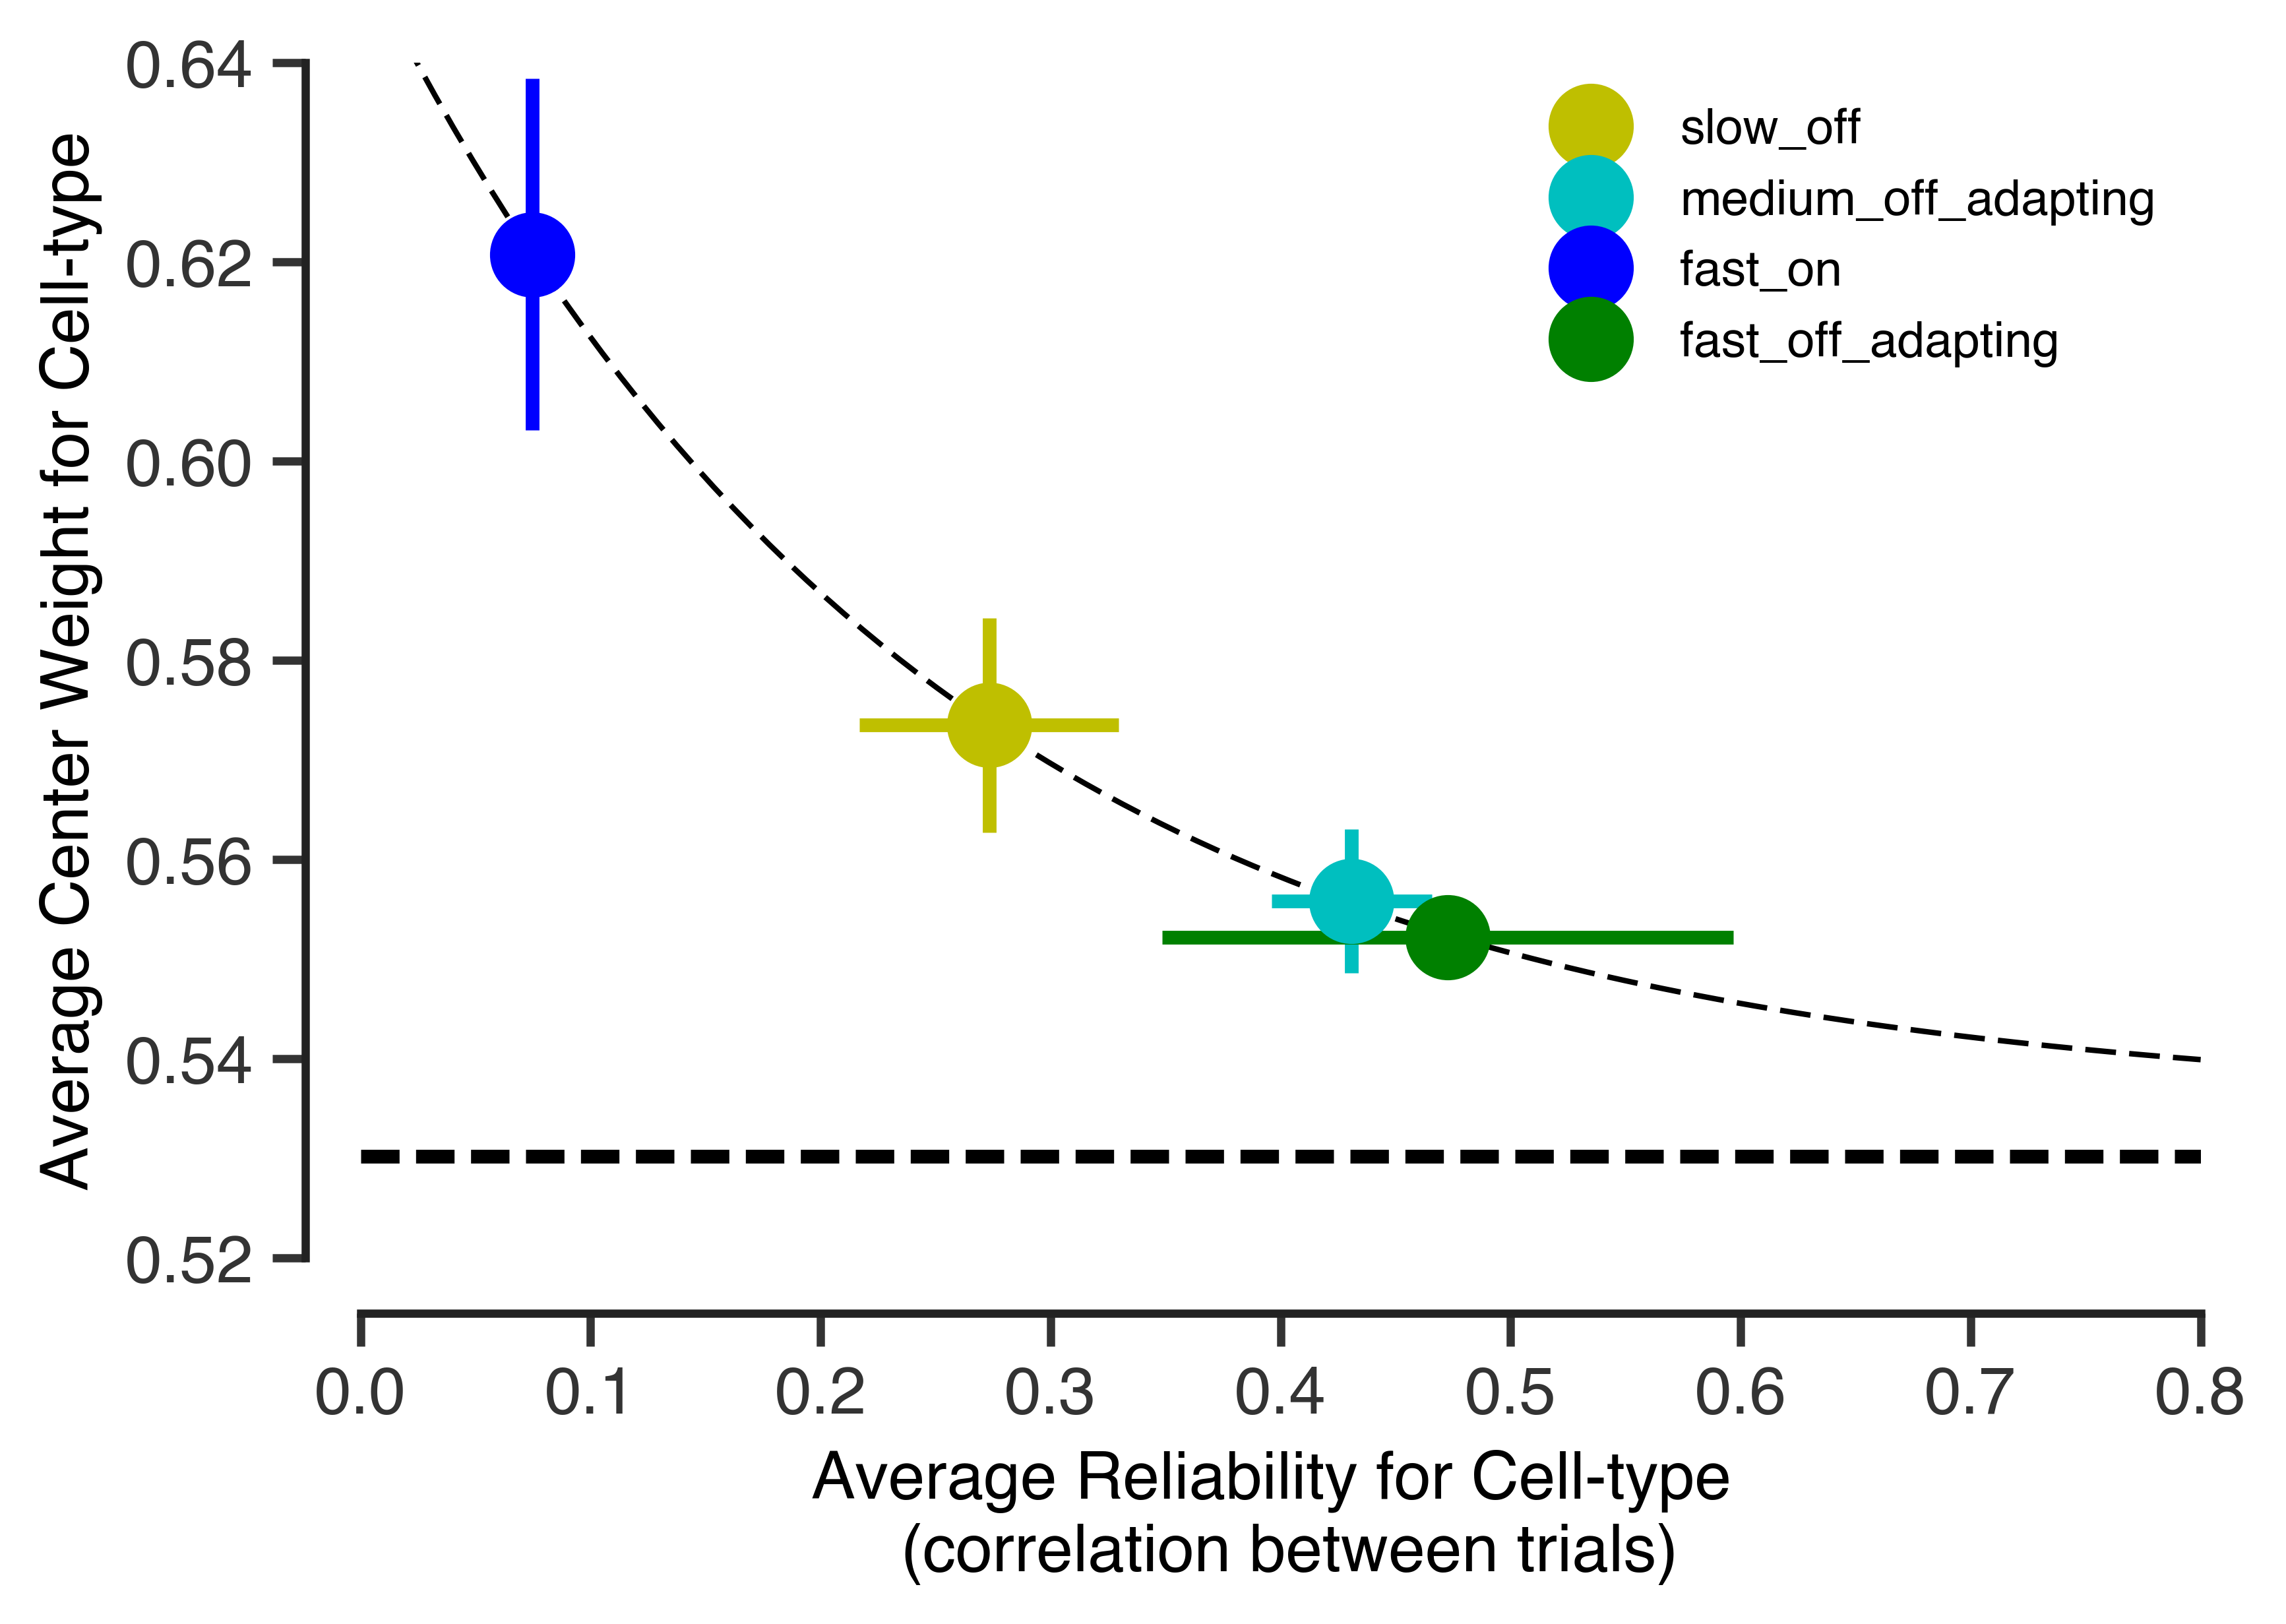

In [99]:
how_far = 0.8

# plot exponential fit
x = np.linspace(0,how_far,100)
plt.plot(x, exponential_fit(x, *popt), 'k--', linewidth=1)

for i,name in enumerate(fit_ordering):
      plt.errorbar(mean_reliability[i], mean_cws[i], yerr=sem_cws[i], xerr=sem_reliability[i], fmt='o',
                  label=name, color=colorscheme[name])
        
plt.plot(np.linspace(0,how_far,10), 10*[ideal_cw], 'k--')

# plt.errorbar(mean_reliability[:-1], mean_cws, yerr=sem_cws, xerr=sem_reliability[:-1], fmt='o')
plt.legend(loc='upper right', frameon=False, fontsize=9)
plt.xlabel('Average Reliability for Cell-type \n (correlation between trials)')
plt.ylabel('Average Center Weight for Cell-type')
plt.xlim(0,how_far)
plt.ylim(0.52, 0.64)
adjust_spines(plt.gca())